In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr.detach())
        x_cls = discriminator(x)
        
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        # Perceptual loss
        perceptual_loss = PerceptualLoss()(y_pr, y)
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss
        _loss.backward()    
        gen_optimizer.step()
        

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        perceptual_l += perceptual_loss.item()

    return  air_l/(index+1), bone_l/(index+1), perceptual_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [16]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [17]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [18]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [19]:
len(trainset), len(testset)

(1344, 191)

In [20]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f54bc74e730>,)

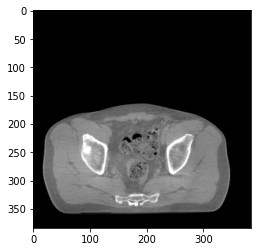

In [21]:
plt.imshow(x.squeeze(), 'gray'),

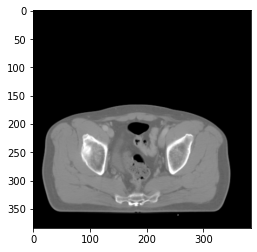

In [22]:
plt.imshow(y.squeeze(), 'gray')

In [23]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [24]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [26]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [27]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [28]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [29]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_perceptual, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss perceptual": loss_perceptual,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [05:48,  2.07s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.40it/s]
168it [05:49,  2.08s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.38it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.40it/s]
168it [05:48,  2.08s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.40it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.39it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.40it/s]
168it [05:49,  2.08s/it]
168it [00:47,  3.53it/s]
24it [00:07,  3.37it/s]
168it [05:52,  2.10s/it]
168it [00:47,  3.53it/s]
24it [00:07,  3.39it/s]
168it [05:49,  2.08s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.38it/s]
168it [05:48,  2.08s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.39it/s]
168it [05:48,  2.08s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.39it/s]
168it [05:49,  2.08s/it]
168it [00:47,  3.55it/s]
24it [00:07,  3.38it/s]
168it [05:48,  2.07s/it]
168it [00:47,  3.54it/s]
24it [00:07,  3.40it/s]
168it [05:48,  2.08s/it]
168it [00:47,

In [30]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [31]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [32]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8961079716682434
psnr score = 25.804752349853516
snr score = 15.867691993713379
mae error = 0.015964003279805183
air dice score = 0.9986912433188484
bone dice score = 0.9737031182644963


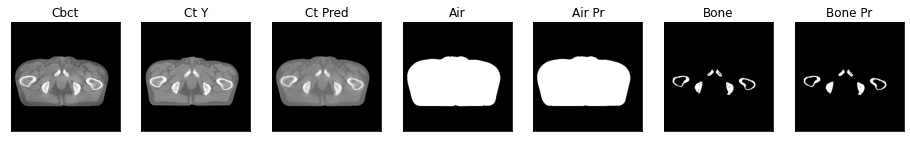

ssim score = 0.896893322467804
psnr score = 25.731821060180664
snr score = 15.842294692993164
mae error = 0.016119780018925667
air dice score = 0.9984025559105447
bone dice score = 0.9748715019992166


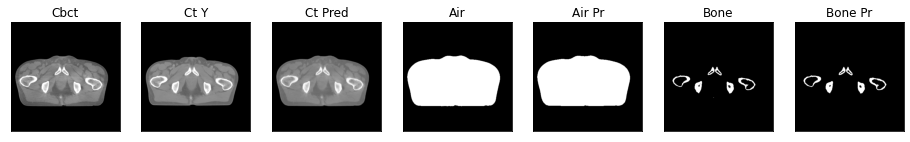

ssim score = 0.8952608704566956
psnr score = 25.690093994140625
snr score = 15.963462829589844
mae error = 0.016723595559597015
air dice score = 0.9986110972331872
bone dice score = 0.9736559780668296


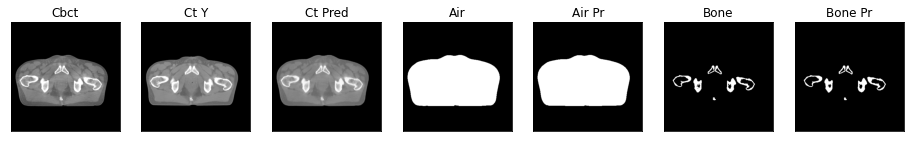

ssim score = 0.8923956155776978
psnr score = 25.814132690429688
snr score = 16.176755905151367
mae error = 0.016654882580041885
air dice score = 0.9986889380398135
bone dice score = 0.9680384820954779


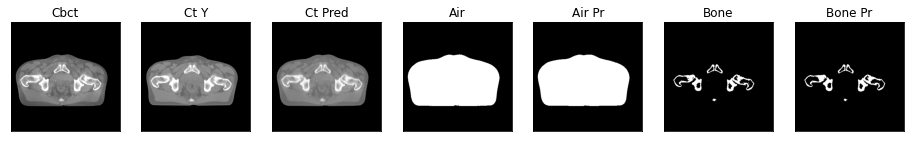

ssim score = 0.891685962677002
psnr score = 25.91944694519043
snr score = 16.322372436523438
mae error = 0.016735954210162163
air dice score = 0.9985441913233818
bone dice score = 0.9652273595723613


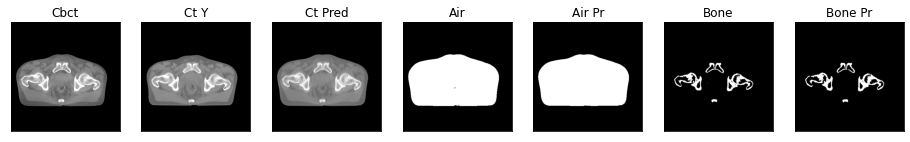

ssim score = 0.885504961013794
psnr score = 25.830108642578125
snr score = 16.36956787109375
mae error = 0.017163434997200966
air dice score = 0.9983865112339172
bone dice score = 0.9673921838339073


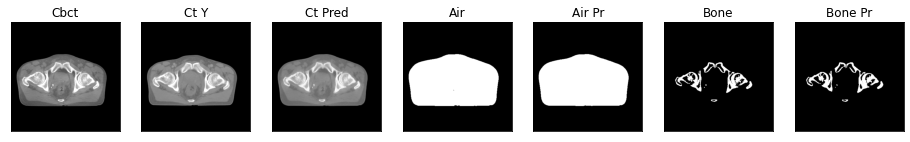

ssim score = 0.8832632899284363
psnr score = 25.764347076416016
snr score = 16.27975082397461
mae error = 0.01753358729183674
air dice score = 0.9976855141610013
bone dice score = 0.966661473750065


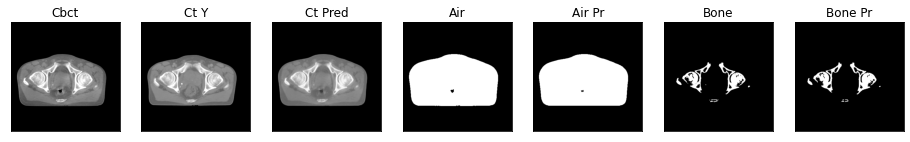

ssim score = 0.8842149376869202
psnr score = 26.004533767700195
snr score = 16.33439826965332
mae error = 0.016905363649129868
air dice score = 0.9976927945770487
bone dice score = 0.9711092003441865


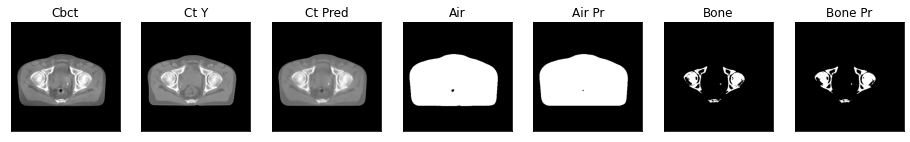

1it [00:02,  2.70s/it]

ssim score = 0.8869921565055847
psnr score = 26.268827438354492
snr score = 16.504138946533203
mae error = 0.01622442528605461
air dice score = 0.9982442991057238
bone dice score = 0.9756557841104392


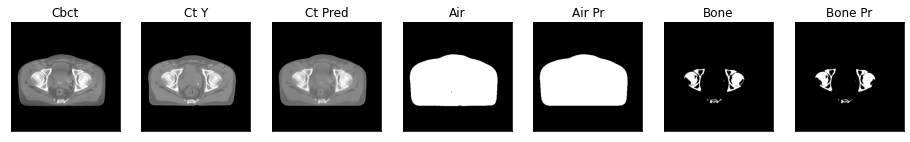

ssim score = 0.89183509349823
psnr score = 26.48067855834961
snr score = 16.70070457458496
mae error = 0.015871062874794006
air dice score = 0.9980448343281595
bone dice score = 0.9693658536588354


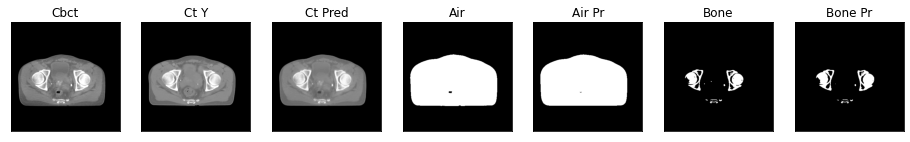

ssim score = 0.8979301452636719
psnr score = 26.804859161376953
snr score = 17.057157516479492
mae error = 0.015237891115248203
air dice score = 0.9981577660050602
bone dice score = 0.9760184312495966


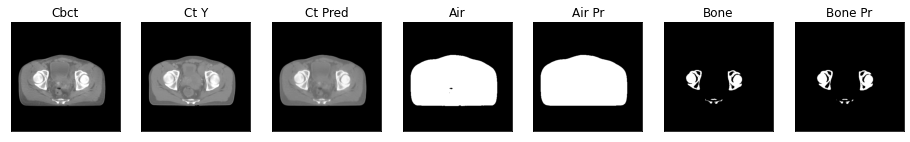

ssim score = 0.897811233997345
psnr score = 26.435749053955078
snr score = 16.71175765991211
mae error = 0.015926241874694824
air dice score = 0.9980214691643885
bone dice score = 0.9789858860430843


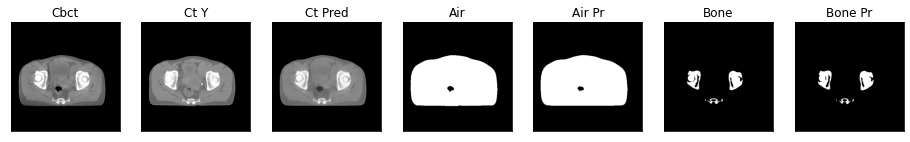

ssim score = 0.9020872116088867
psnr score = 26.236764907836914
snr score = 16.480850219726562
mae error = 0.016075458377599716
air dice score = 0.9978612698311383
bone dice score = 0.980586907449429


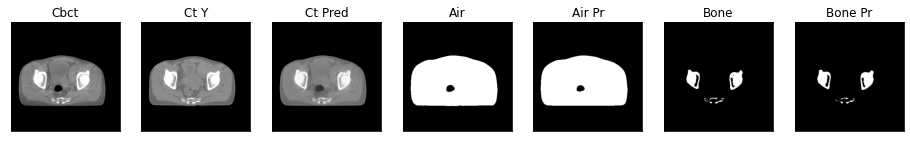

ssim score = 0.9009583592414856
psnr score = 26.043378829956055
snr score = 16.1455078125
mae error = 0.016345907002687454
air dice score = 0.9982404566229661
bone dice score = 0.9678606476942118


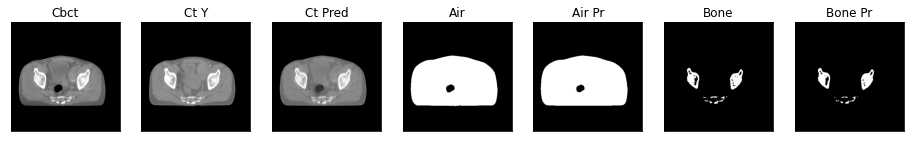

ssim score = 0.8987987041473389
psnr score = 25.69748306274414
snr score = 15.713950157165527
mae error = 0.016927460208535194
air dice score = 0.9980005403944902
bone dice score = 0.9642950221531887


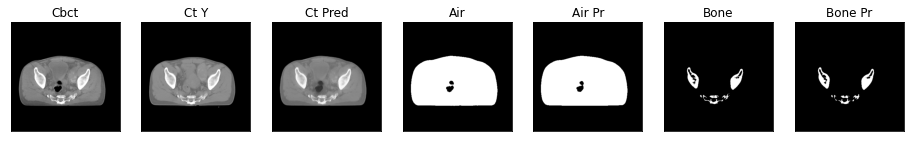

ssim score = 0.8925157189369202
psnr score = 25.173349380493164
snr score = 15.213298797607422
mae error = 0.017781132832169533
air dice score = 0.998263021907638
bone dice score = 0.9699666295888028


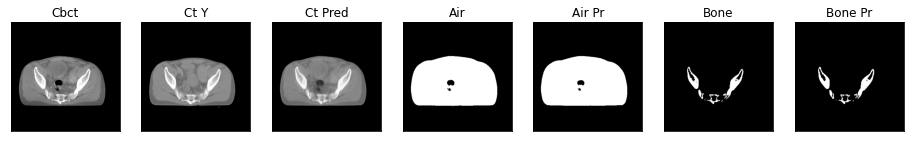

2it [00:04,  2.51s/it]

ssim score = 0.8897740244865417
psnr score = 24.553390502929688
snr score = 14.590798377990723
mae error = 0.018870599567890167
air dice score = 0.9975729488122851
bone dice score = 0.9711459192089136


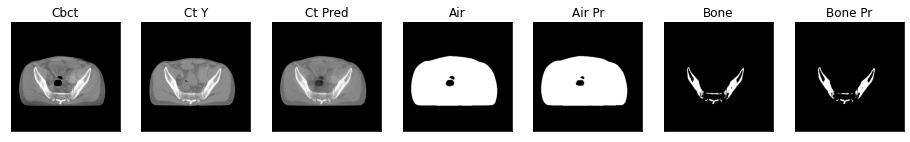

ssim score = 0.8832322359085083
psnr score = 23.937397003173828
snr score = 13.873044967651367
mae error = 0.020412525162100792
air dice score = 0.9970517227951926
bone dice score = 0.9627166943723258


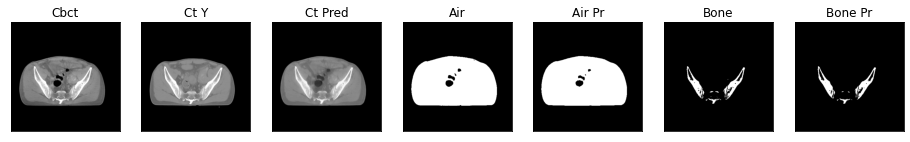

ssim score = 0.8811813592910767
psnr score = 23.431264877319336
snr score = 13.316229820251465
mae error = 0.021361473947763443
air dice score = 0.996651233874234
bone dice score = 0.9515941354438957


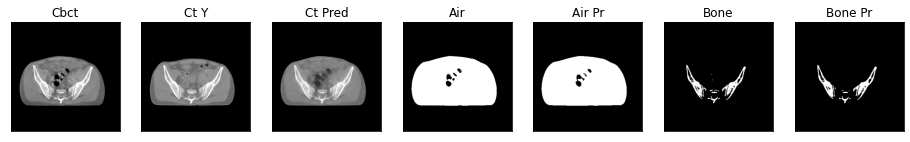

ssim score = 0.8828958868980408
psnr score = 23.32558822631836
snr score = 13.198246002197266
mae error = 0.021195730194449425
air dice score = 0.9971643224312295
bone dice score = 0.9517970909970933


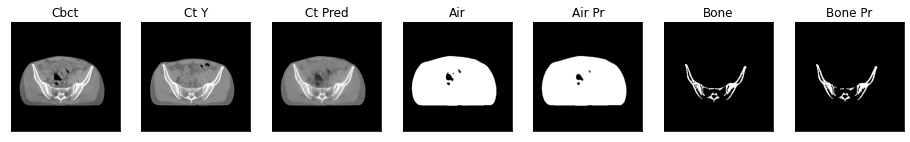

ssim score = 0.8790977597236633
psnr score = 23.184051513671875
snr score = 12.991859436035156
mae error = 0.021137602627277374
air dice score = 0.998350679633739
bone dice score = 0.9495951945684304


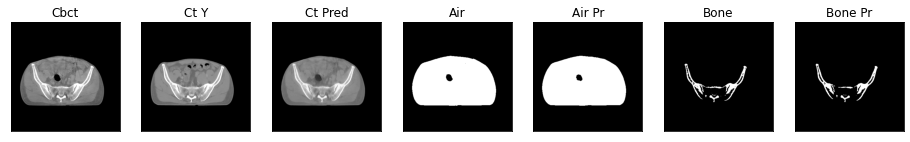

ssim score = 0.8776435256004333
psnr score = 23.053485870361328
snr score = 12.801865577697754
mae error = 0.021422652527689934
air dice score = 0.9972174952858424
bone dice score = 0.9581252401081044


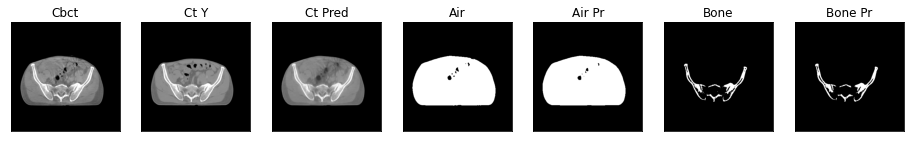

ssim score = 0.8814840316772461
psnr score = 23.125877380371094
snr score = 12.840829849243164
mae error = 0.02067948691546917
air dice score = 0.9977755120956555
bone dice score = 0.9621492537317952


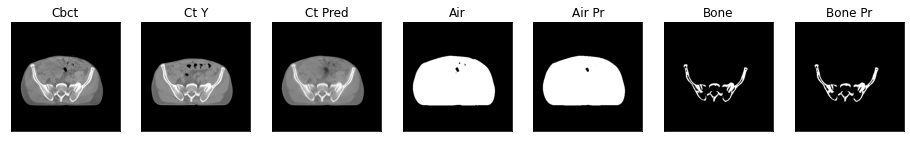

ssim score = 0.881902813911438
psnr score = 23.124553680419922
snr score = 12.790942192077637
mae error = 0.020734291523694992
air dice score = 0.9973430093053229
bone dice score = 0.9567523930347509


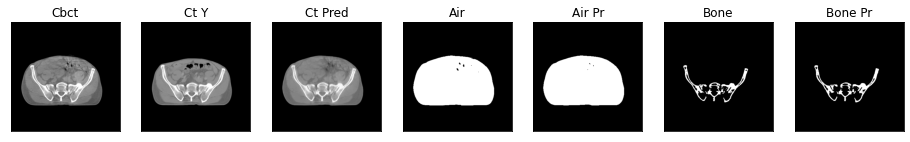

3it [00:07,  2.44s/it]

ssim score = 0.8814435601234436
psnr score = 22.997940063476562
snr score = 12.567327499389648
mae error = 0.020963722839951515
air dice score = 0.9984813971146563
bone dice score = 0.96140195208561


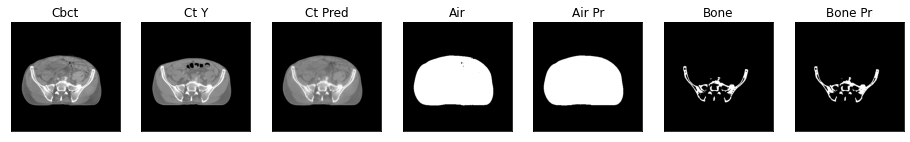

ssim score = 0.8843070268630981
psnr score = 23.25201988220215
snr score = 12.738672256469727
mae error = 0.02018340304493904
air dice score = 0.9979293057725168
bone dice score = 0.9587378640781251


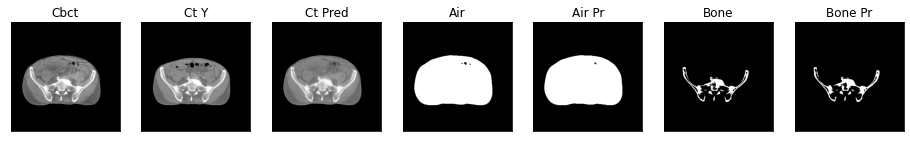

ssim score = 0.8839871287345886
psnr score = 23.369945526123047
snr score = 12.765412330627441
mae error = 0.020289983600378036
air dice score = 0.99787575645301
bone dice score = 0.963388214905076


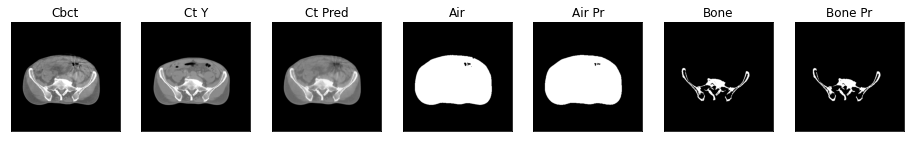

ssim score = 0.8837772607803345
psnr score = 23.19482421875
snr score = 12.549181938171387
mae error = 0.02109098993241787
air dice score = 0.9974395019580311
bone dice score = 0.9621900826450187


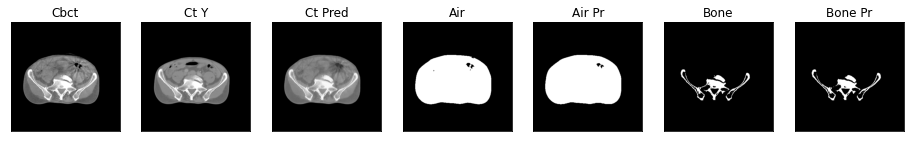

ssim score = 0.8647851943969727
psnr score = 23.933218002319336
snr score = 15.305375099182129
mae error = 0.024045391008257866
air dice score = 0.9987005685012815
bone dice score = 0.9882800126706278


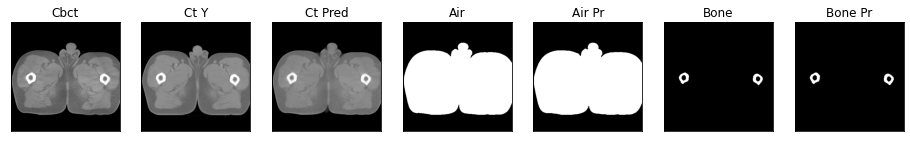

ssim score = 0.872755229473114
psnr score = 24.395137786865234
snr score = 15.80655288696289
mae error = 0.023094939067959785
air dice score = 0.9987985086643635
bone dice score = 0.9875959834616777


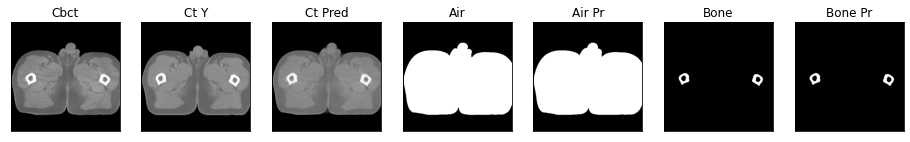

ssim score = 0.8802380561828613
psnr score = 24.84378433227539
snr score = 16.342647552490234
mae error = 0.02231956273317337
air dice score = 0.9988004945653184
bone dice score = 0.983889796871728


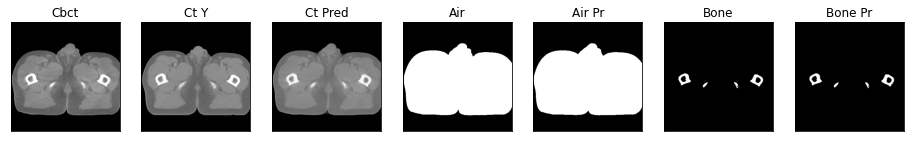

ssim score = 0.8870596885681152
psnr score = 25.217954635620117
snr score = 16.879375457763672
mae error = 0.021709173917770386
air dice score = 0.9989913377306939
bone dice score = 0.9817893903407476


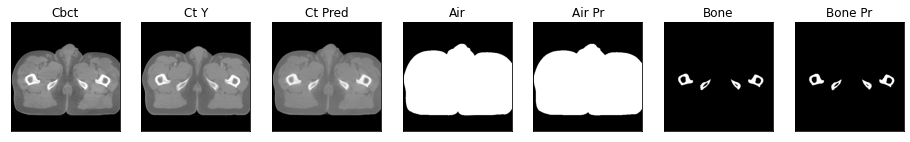

4it [00:09,  2.33s/it]

ssim score = 0.8907063603401184
psnr score = 25.511016845703125
snr score = 17.300580978393555
mae error = 0.0211087204515934
air dice score = 0.9991171617664076
bone dice score = 0.979915288974178


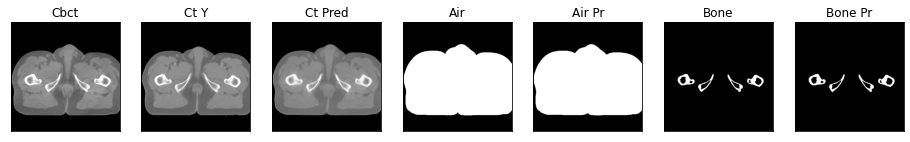

ssim score = 0.895016610622406
psnr score = 26.030529022216797
snr score = 17.92333221435547
mae error = 0.02036328800022602
air dice score = 0.9989325699591229
bone dice score = 0.974875562929902


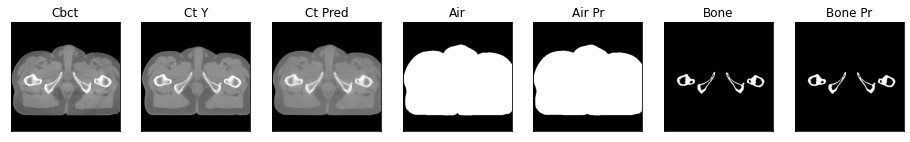

ssim score = 0.8963984251022339
psnr score = 26.39949607849121
snr score = 18.359397888183594
mae error = 0.020316246896982193
air dice score = 0.9989304554326224
bone dice score = 0.9706073049495287


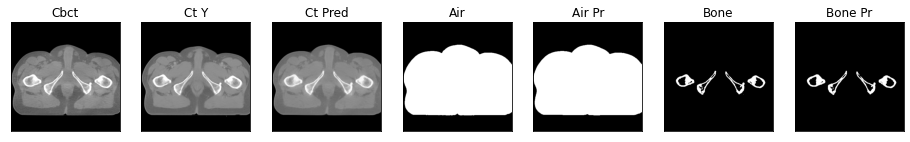

ssim score = 0.8963472247123718
psnr score = 26.451805114746094
snr score = 18.401819229125977
mae error = 0.020311636850237846
air dice score = 0.9990964943982659
bone dice score = 0.9760903027195886


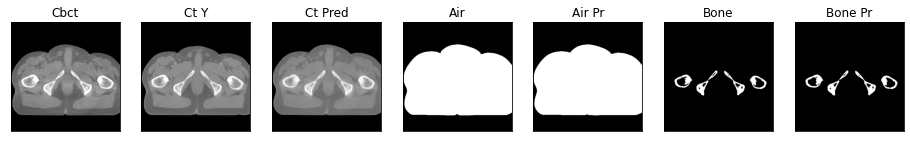

ssim score = 0.8998937606811523
psnr score = 26.552371978759766
snr score = 18.488719940185547
mae error = 0.020144041627645493
air dice score = 0.9988333914633126
bone dice score = 0.9780353874315839


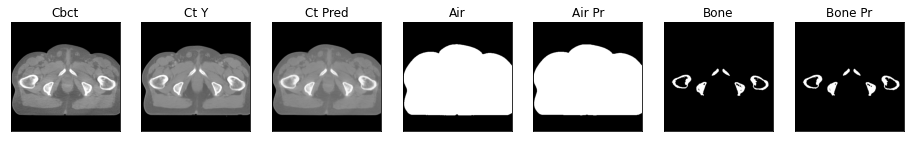

ssim score = 0.8993552923202515
psnr score = 26.62327003479004
snr score = 18.57162094116211
mae error = 0.020330760627985
air dice score = 0.9990511194388398
bone dice score = 0.9767991407091644


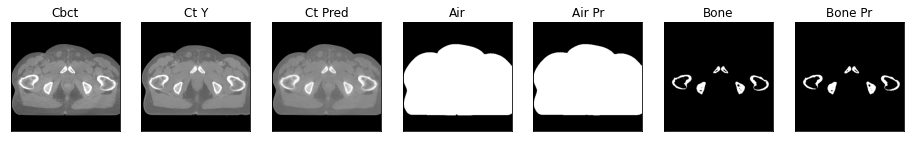

ssim score = 0.9014803171157837
psnr score = 26.693988800048828
snr score = 18.68142318725586
mae error = 0.01995708793401718
air dice score = 0.9990398348515951
bone dice score = 0.9721792890265822


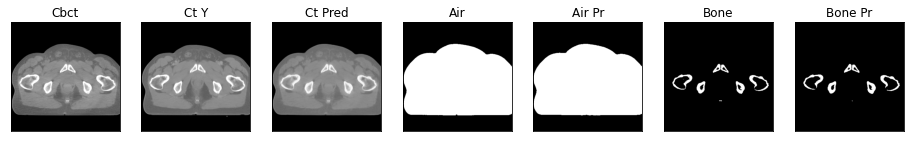

ssim score = 0.898860514163971
psnr score = 26.789478302001953
snr score = 18.918203353881836
mae error = 0.01995816081762314
air dice score = 0.9990997155101017
bone dice score = 0.9725911274373873


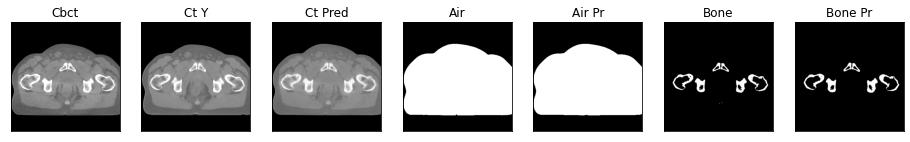

5it [00:11,  2.32s/it]

ssim score = 0.9002743363380432
psnr score = 26.950185775756836
snr score = 19.173595428466797
mae error = 0.020014656707644463
air dice score = 0.9990744858588657
bone dice score = 0.9780168381666822


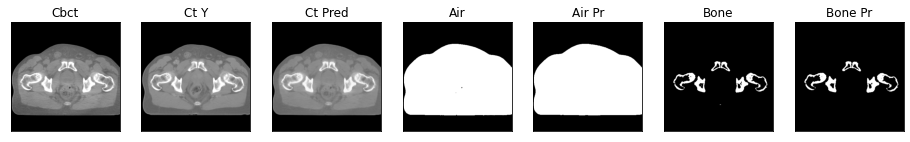

ssim score = 0.8911073803901672
psnr score = 26.135944366455078
snr score = 18.325307846069336
mae error = 0.02205251343548298
air dice score = 0.9986188261831963
bone dice score = 0.9662785422654901


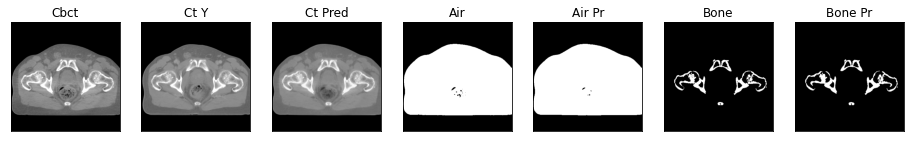

ssim score = 0.8946235775947571
psnr score = 25.79415512084961
snr score = 18.055706024169922
mae error = 0.02254868857562542
air dice score = 0.9980985474846772
bone dice score = 0.9616302315085985


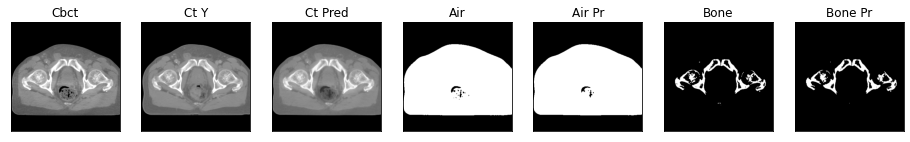

ssim score = 0.8919932842254639
psnr score = 26.12902069091797
snr score = 18.25447654724121
mae error = 0.021492905914783478
air dice score = 0.9984101167741827
bone dice score = 0.9535390808457436


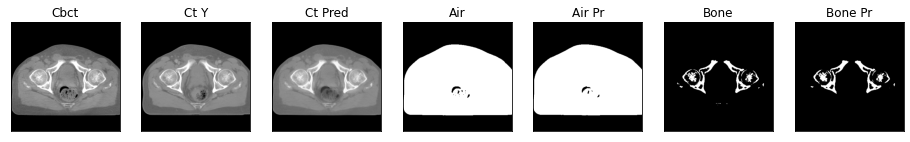

ssim score = 0.8959861993789673
psnr score = 26.356523513793945
snr score = 18.303417205810547
mae error = 0.02059336192905903
air dice score = 0.9985648416745558
bone dice score = 0.9539448848626468


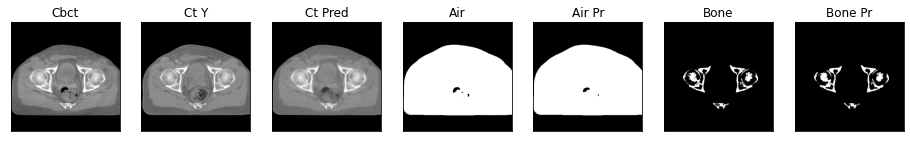

ssim score = 0.8925610184669495
psnr score = 25.938615798950195
snr score = 17.794919967651367
mae error = 0.021338343620300293
air dice score = 0.9988259896540346
bone dice score = 0.9494754870482822


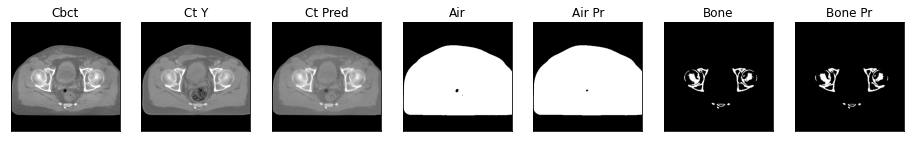

ssim score = 0.8922645449638367
psnr score = 25.740930557250977
snr score = 17.612926483154297
mae error = 0.021128013730049133
air dice score = 0.9993247971322297
bone dice score = 0.9550338241150514


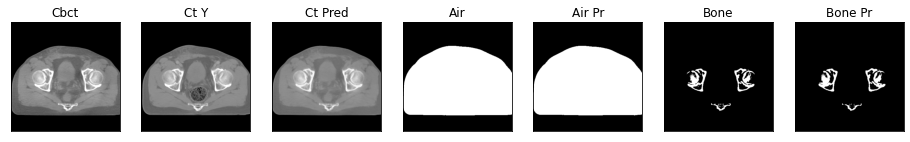

ssim score = 0.8801385164260864
psnr score = 25.666532516479492
snr score = 17.548564910888672
mae error = 0.021932387724518776
air dice score = 0.9990680795650221
bone dice score = 0.959461851655519


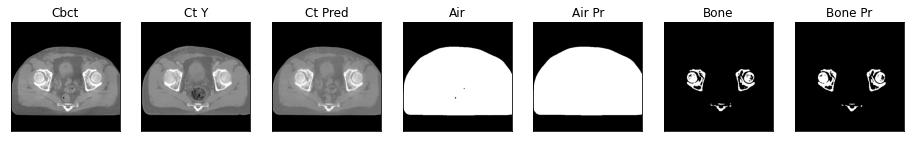

6it [00:13,  2.32s/it]

ssim score = 0.8892344832420349
psnr score = 26.185152053833008
snr score = 18.128774642944336
mae error = 0.021121317520737648
air dice score = 0.9991452462062563
bone dice score = 0.9737071217136192


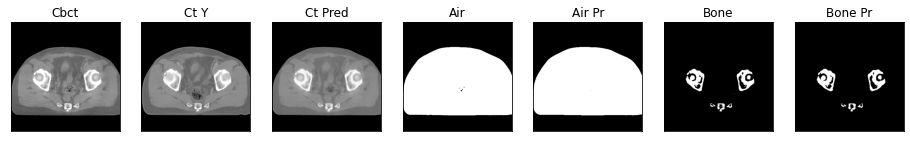

ssim score = 0.8889021277427673
psnr score = 26.732589721679688
snr score = 18.746294021606445
mae error = 0.020164037123322487
air dice score = 0.9990561820078492
bone dice score = 0.9800325649157594


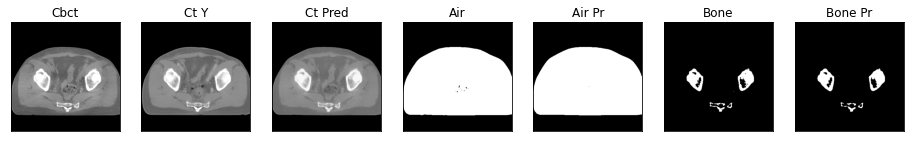

ssim score = 0.8919402360916138
psnr score = 26.134130477905273
snr score = 18.02872657775879
mae error = 0.02145090140402317
air dice score = 0.9989381454181913
bone dice score = 0.9799394398185093


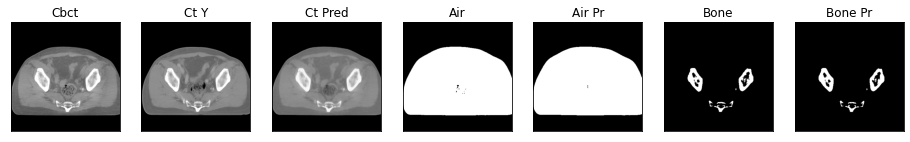

ssim score = 0.8848553895950317
psnr score = 25.817859649658203
snr score = 17.794082641601562
mae error = 0.022483715787529945
air dice score = 0.99836118491297
bone dice score = 0.980823276574799


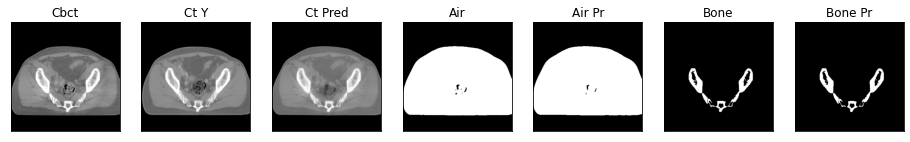

ssim score = 0.8873017430305481
psnr score = 25.823781967163086
snr score = 17.88015365600586
mae error = 0.02255266346037388
air dice score = 0.9982003673732821
bone dice score = 0.9800977894085801


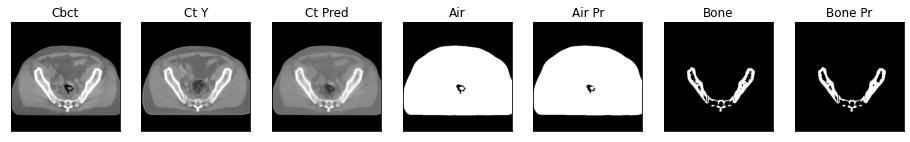

ssim score = 0.8711150884628296
psnr score = 25.218692779541016
snr score = 17.296621322631836
mae error = 0.024939995259046555
air dice score = 0.9985469699686526
bone dice score = 0.9721187025536776


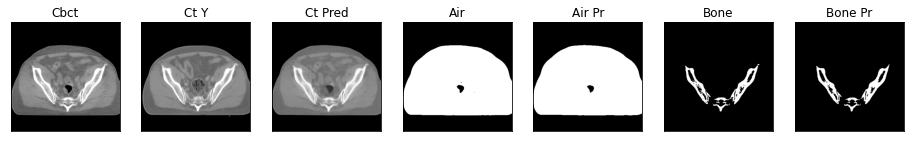

ssim score = 0.8700782060623169
psnr score = 25.461029052734375
snr score = 17.551494598388672
mae error = 0.02417990379035473
air dice score = 0.9985153738558572
bone dice score = 0.9780304625536742


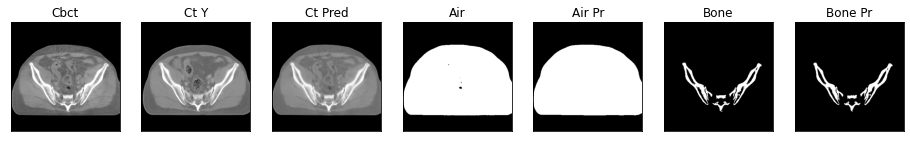

ssim score = 0.8109124302864075
psnr score = 21.259475708007812
snr score = 11.139683723449707
mae error = 0.03113386034965515
air dice score = 0.9831166310887018
bone dice score = 0.9797482211280857


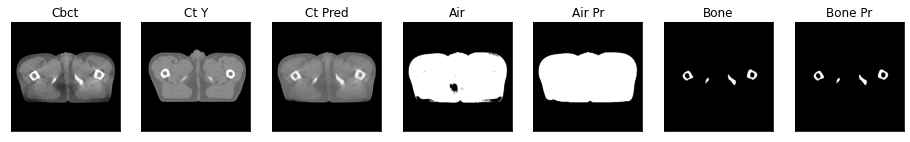

7it [00:15,  2.25s/it]

ssim score = 0.8003076910972595
psnr score = 20.93889045715332
snr score = 11.032076835632324
mae error = 0.03326505795121193
air dice score = 0.9837271983000637
bone dice score = 0.9687021230035303


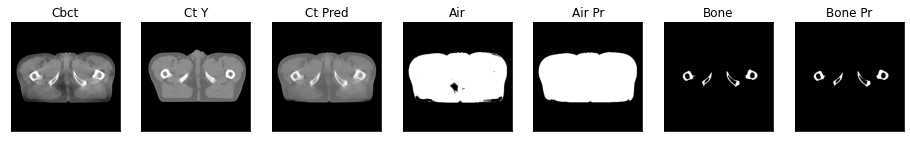

ssim score = 0.7967393398284912
psnr score = 20.961082458496094
snr score = 11.18541145324707
mae error = 0.033646631985902786
air dice score = 0.9844586127093747
bone dice score = 0.9492858621413934


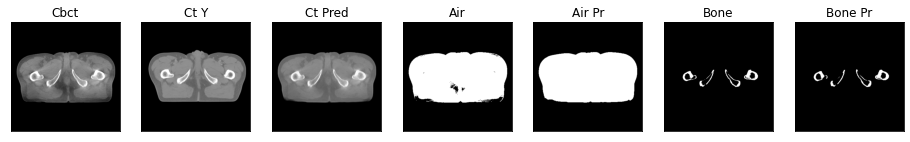

ssim score = 0.8005558848381042
psnr score = 21.301166534423828
snr score = 11.59589672088623
mae error = 0.03250717744231224
air dice score = 0.9835297133492785
bone dice score = 0.9559497707802282


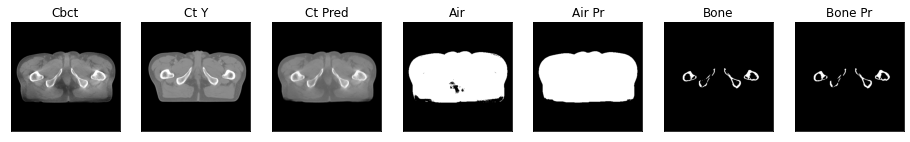

ssim score = 0.8000719547271729
psnr score = 21.301143646240234
snr score = 11.643440246582031
mae error = 0.032621830701828
air dice score = 0.9856939527754592
bone dice score = 0.9511538461547855


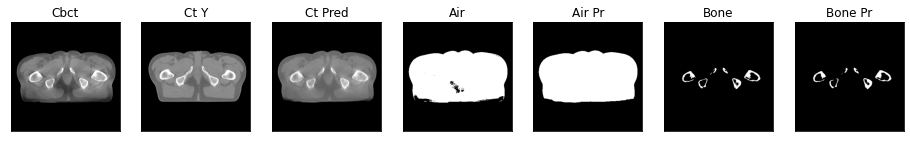

ssim score = 0.8017624020576477
psnr score = 21.472137451171875
snr score = 11.820048332214355
mae error = 0.03189462423324585
air dice score = 0.9850496526135962
bone dice score = 0.9563440460717751


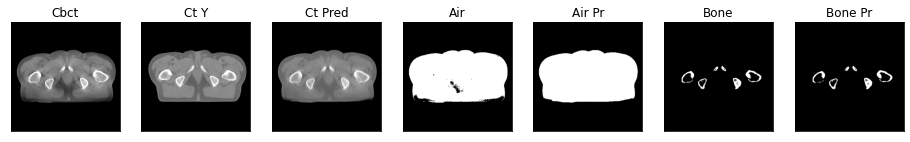

ssim score = 0.807081937789917
psnr score = 21.624649047851562
snr score = 11.966056823730469
mae error = 0.031029757112264633
air dice score = 0.9856665549931768
bone dice score = 0.9647103227030627


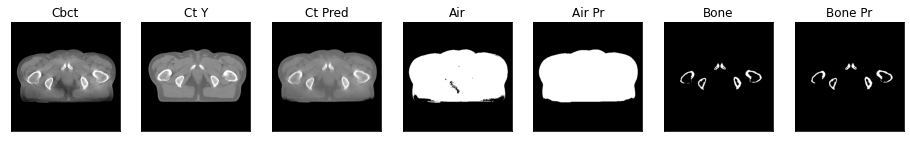

ssim score = 0.8063713908195496
psnr score = 21.496732711791992
snr score = 11.852250099182129
mae error = 0.03125831112265587
air dice score = 0.9872121381197189
bone dice score = 0.9655680353532394


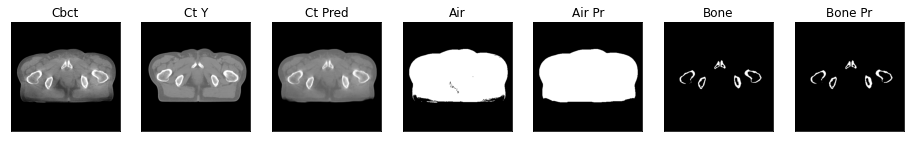

ssim score = 0.8044859170913696
psnr score = 21.408546447753906
snr score = 11.822071075439453
mae error = 0.03206674009561539
air dice score = 0.9881059165440887
bone dice score = 0.9541193882592646


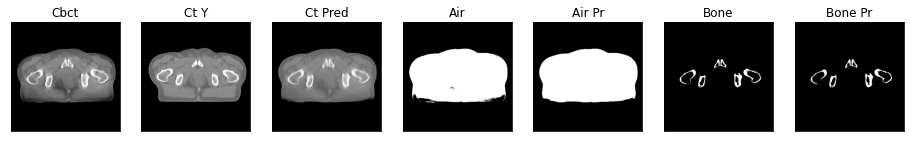

8it [00:18,  2.26s/it]

ssim score = 0.7967570424079895
psnr score = 21.28162384033203
snr score = 11.793709754943848
mae error = 0.03349876403808594
air dice score = 0.9888028951234469
bone dice score = 0.9452830188687849


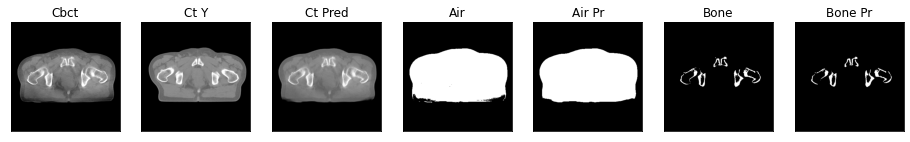

ssim score = 0.7857935428619385
psnr score = 21.148584365844727
snr score = 11.696499824523926
mae error = 0.03464166447520256
air dice score = 0.9871013845466842
bone dice score = 0.941440095608882


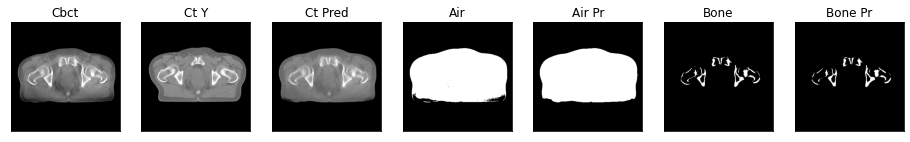

ssim score = 0.7753499746322632
psnr score = 20.993682861328125
snr score = 11.574305534362793
mae error = 0.03517996519804001
air dice score = 0.9860620967454585
bone dice score = 0.9275056120437408


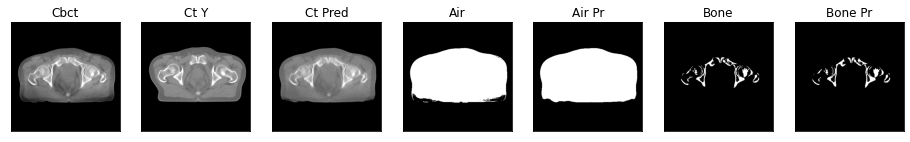

ssim score = 0.7762534022331238
psnr score = 21.04936408996582
snr score = 11.74680233001709
mae error = 0.03527035191655159
air dice score = 0.9859729070616213
bone dice score = 0.9407756813424951


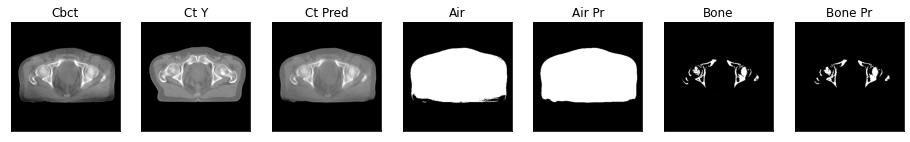

ssim score = 0.7792227268218994
psnr score = 20.957963943481445
snr score = 11.63941478729248
mae error = 0.03546891734004021
air dice score = 0.9850788764225026
bone dice score = 0.933333333334308


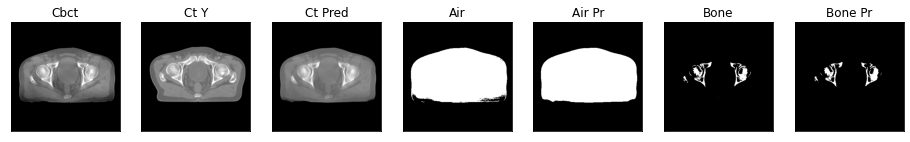

ssim score = 0.7945239543914795
psnr score = 21.50818634033203
snr score = 11.990474700927734
mae error = 0.0321931391954422
air dice score = 0.984332322037079
bone dice score = 0.9494224164853353


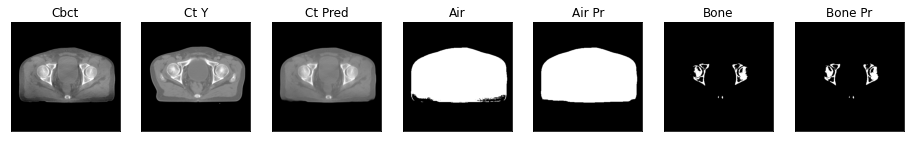

ssim score = 0.8104824423789978
psnr score = 22.221782684326172
snr score = 12.533676147460938
mae error = 0.02906898967921734
air dice score = 0.9842561660388227
bone dice score = 0.9604664391359433


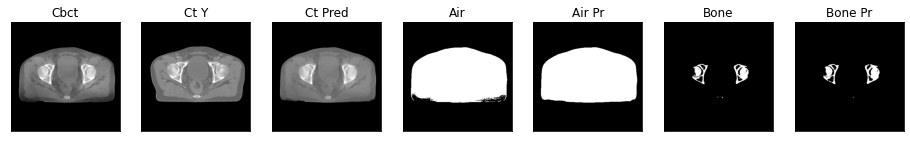

ssim score = 0.816243588924408
psnr score = 22.566701889038086
snr score = 12.892765998840332
mae error = 0.028024906292557716
air dice score = 0.9837475674667143
bone dice score = 0.9646629286743427


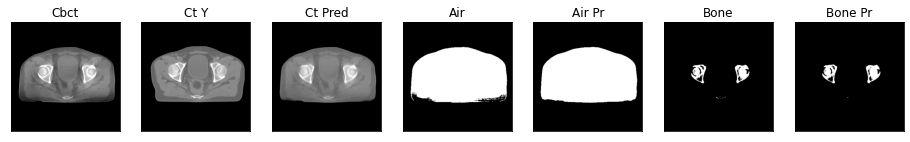

9it [00:20,  2.20s/it]

ssim score = 0.8187581896781921
psnr score = 22.653339385986328
snr score = 13.06123161315918
mae error = 0.028121398761868477
air dice score = 0.9841010136937719
bone dice score = 0.9731525784160932


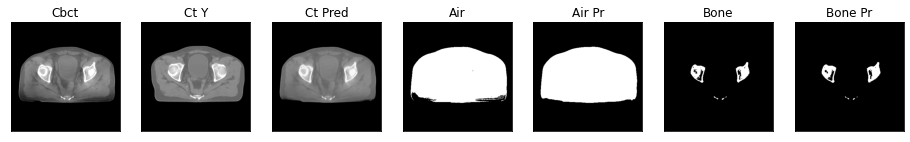

ssim score = 0.8170711994171143
psnr score = 22.53099822998047
snr score = 13.03106689453125
mae error = 0.028932899236679077
air dice score = 0.9832646389994464
bone dice score = 0.9682754473016347


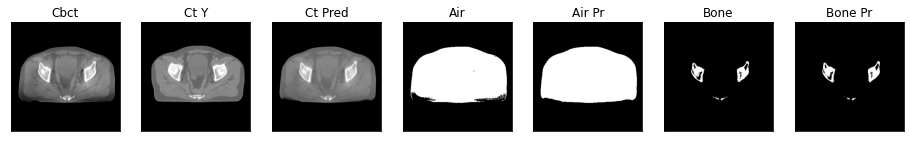

ssim score = 0.8145623207092285
psnr score = 22.885623931884766
snr score = 13.32226276397705
mae error = 0.02771354652941227
air dice score = 0.9832305795314574
bone dice score = 0.9738670195174683


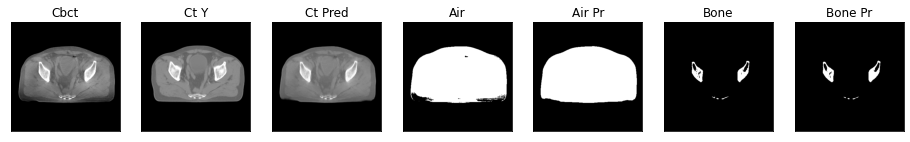

ssim score = 0.8199732303619385
psnr score = 23.185426712036133
snr score = 13.585671424865723
mae error = 0.026606161147356033
air dice score = 0.9831963068806479
bone dice score = 0.9767608151595145


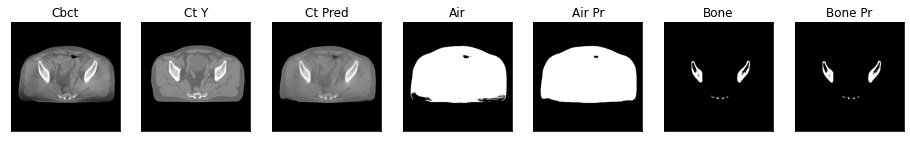

ssim score = 0.8194332122802734
psnr score = 22.999465942382812
snr score = 13.437456130981445
mae error = 0.028046734631061554
air dice score = 0.9834367621371726
bone dice score = 0.9606325152370181


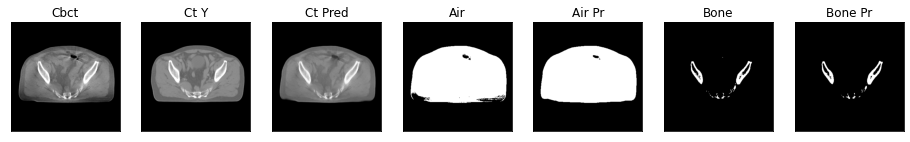

ssim score = 0.8161518573760986
psnr score = 22.878028869628906
snr score = 13.446525573730469
mae error = 0.02876265160739422
air dice score = 0.9833524734595267
bone dice score = 0.9633418584830443


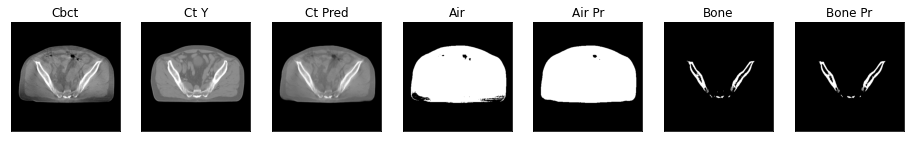

ssim score = 0.818313717842102
psnr score = 22.902992248535156
snr score = 13.489235877990723
mae error = 0.02856101654469967
air dice score = 0.9838498395534011
bone dice score = 0.9515608180847062


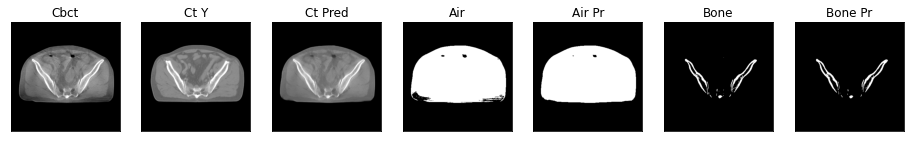

ssim score = 0.820677638053894
psnr score = 23.224578857421875
snr score = 13.799554824829102
mae error = 0.027736758813261986
air dice score = 0.9846142994436596
bone dice score = 0.948215183510169


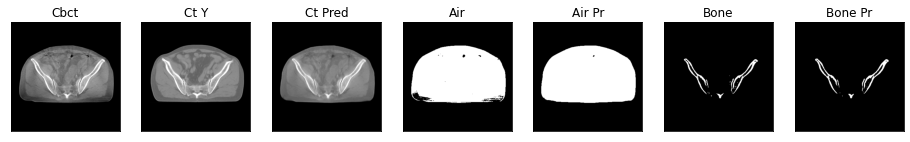

10it [00:22,  2.23s/it]

ssim score = 0.824849545955658
psnr score = 23.345640182495117
snr score = 13.919876098632812
mae error = 0.027058735489845276
air dice score = 0.9847367397110197
bone dice score = 0.9442088091363098


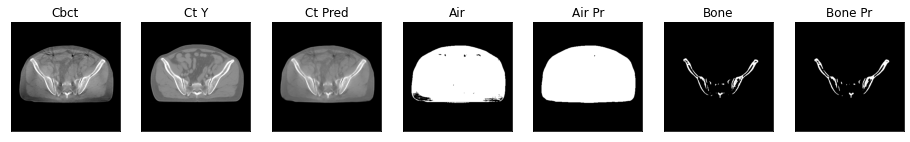

ssim score = 0.8863561153411865
psnr score = 24.69345474243164
snr score = 15.12759017944336
mae error = 0.019468562677502632
air dice score = 0.9984214934604742
bone dice score = 0.9758897818608538


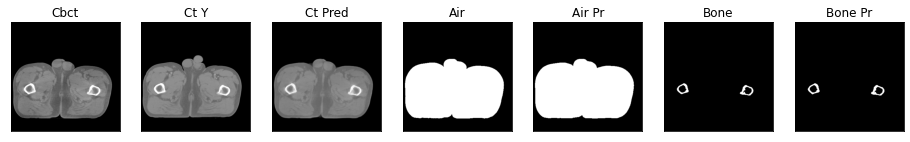

ssim score = 0.883929967880249
psnr score = 24.937246322631836
snr score = 15.435772895812988
mae error = 0.019324075430631638
air dice score = 0.9979894747803257
bone dice score = 0.9677871148470663


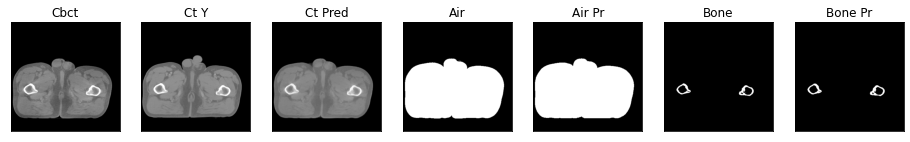

ssim score = 0.8905099630355835
psnr score = 26.663511276245117
snr score = 17.301250457763672
mae error = 0.01795681193470955
air dice score = 0.9975062738982104
bone dice score = 0.9699706480024843


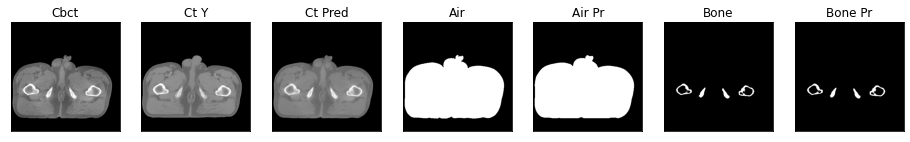

ssim score = 0.8913001418113708
psnr score = 26.493324279785156
snr score = 17.2525577545166
mae error = 0.018122825771570206
air dice score = 0.9976774762433394
bone dice score = 0.9689062839754532


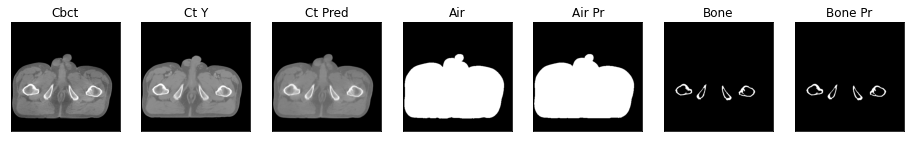

ssim score = 0.8872930407524109
psnr score = 26.180660247802734
snr score = 16.964065551757812
mae error = 0.018262429162859917
air dice score = 0.9978083095703832
bone dice score = 0.960216998192581


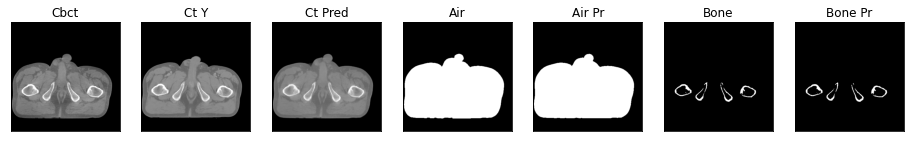

ssim score = 0.8889279961585999
psnr score = 26.022550582885742
snr score = 16.801557540893555
mae error = 0.0182773657143116
air dice score = 0.9980464306169058
bone dice score = 0.9565932935618886


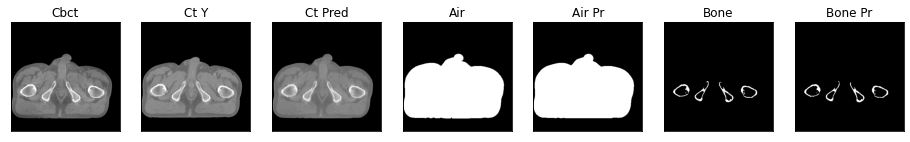

ssim score = 0.8894323706626892
psnr score = 25.482994079589844
snr score = 16.26825523376465
mae error = 0.01899074949324131
air dice score = 0.9981645331325315
bone dice score = 0.9532934131745849


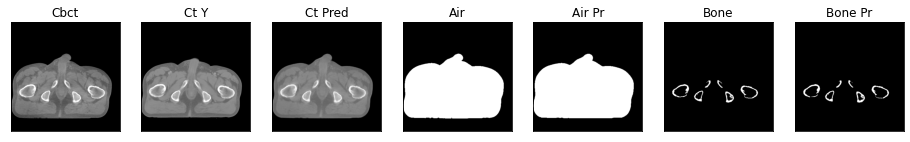

11it [00:24,  2.18s/it]

ssim score = 0.8880102038383484
psnr score = 25.20843505859375
snr score = 15.97214126586914
mae error = 0.01906801387667656
air dice score = 0.9984140941494218
bone dice score = 0.9619047619055178


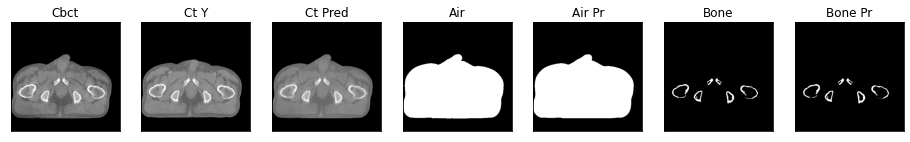

ssim score = 0.8880713582038879
psnr score = 25.2685546875
snr score = 16.049171447753906
mae error = 0.01900194212794304
air dice score = 0.9988661238759674
bone dice score = 0.9607149506616884


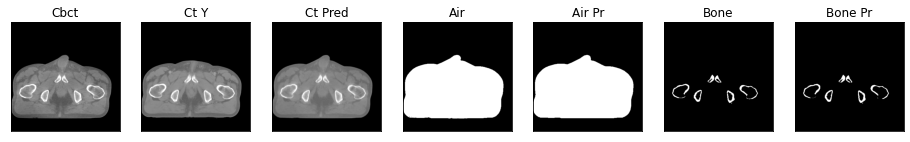

ssim score = 0.8892190456390381
psnr score = 25.62677764892578
snr score = 16.47598648071289
mae error = 0.018413633108139038
air dice score = 0.9990438032921624
bone dice score = 0.9651103994612319


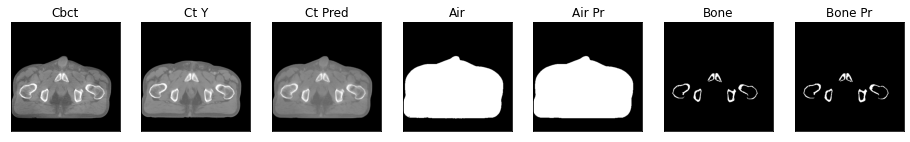

ssim score = 0.8903647661209106
psnr score = 26.092634201049805
snr score = 17.023202896118164
mae error = 0.017964769154787064
air dice score = 0.9990876419113512
bone dice score = 0.9590264941472731


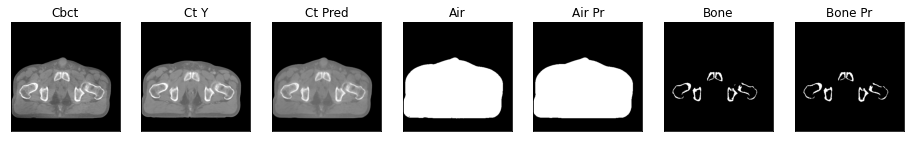

ssim score = 0.8921560645103455
psnr score = 26.70560646057129
snr score = 17.68687629699707
mae error = 0.01759105734527111
air dice score = 0.9988135714683855
bone dice score = 0.9440847557394926


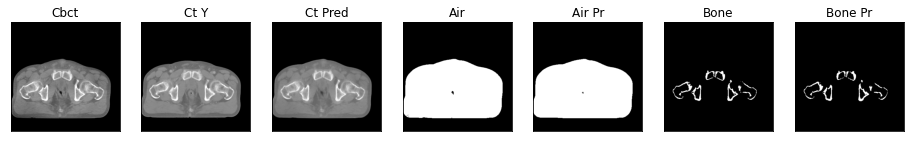

ssim score = 0.8950260281562805
psnr score = 27.27959442138672
snr score = 18.377134323120117
mae error = 0.016737882047891617
air dice score = 0.9988660501812732
bone dice score = 0.9300422746498017


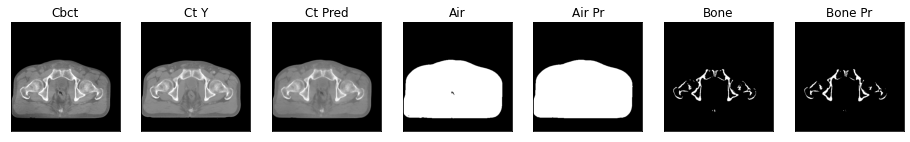

ssim score = 0.8962640762329102
psnr score = 27.43478775024414
snr score = 18.49409294128418
mae error = 0.016660019755363464
air dice score = 0.998513495054359
bone dice score = 0.9250516376523303


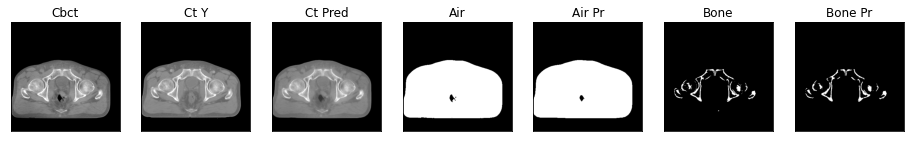

ssim score = 0.8930677175521851
psnr score = 27.12906837463379
snr score = 18.092700958251953
mae error = 0.017237704247236252
air dice score = 0.9980125090248331
bone dice score = 0.9283970707902306


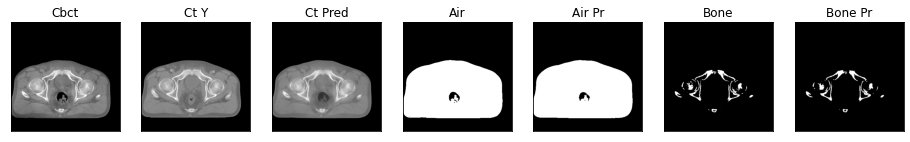

12it [00:26,  2.21s/it]

ssim score = 0.8966196775436401
psnr score = 26.951696395874023
snr score = 17.755571365356445
mae error = 0.017377516254782677
air dice score = 0.9976545580844215
bone dice score = 0.9411764705892239


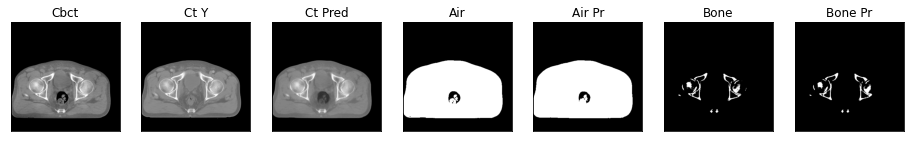

ssim score = 0.8954283595085144
psnr score = 26.798728942871094
snr score = 17.48617935180664
mae error = 0.017278533428907394
air dice score = 0.9983156643218086
bone dice score = 0.9326640124643818


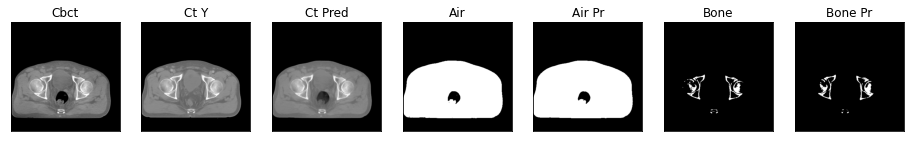

ssim score = 0.8896626234054565
psnr score = 26.390384674072266
snr score = 17.032739639282227
mae error = 0.01777869462966919
air dice score = 0.998196820754013
bone dice score = 0.9456714492996022


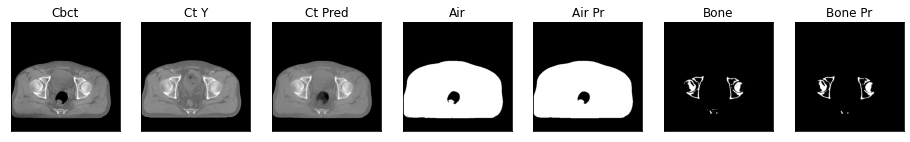

ssim score = 0.881777822971344
psnr score = 25.53093719482422
snr score = 16.17996597290039
mae error = 0.01956678368151188
air dice score = 0.9981760791531692
bone dice score = 0.9589522440511268


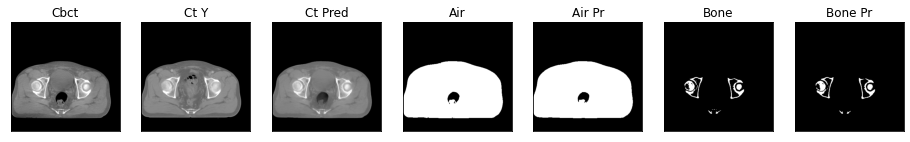

ssim score = 0.8823983073234558
psnr score = 24.980764389038086
snr score = 15.659895896911621
mae error = 0.02058352902531624
air dice score = 0.9979891027727036
bone dice score = 0.9670560047923472


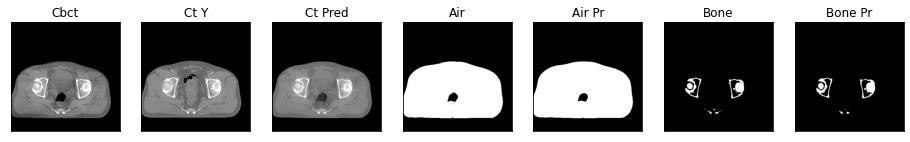

ssim score = 0.8873793482780457
psnr score = 25.172454833984375
snr score = 15.809000968933105
mae error = 0.019664878025650978
air dice score = 0.9980498049804997
bone dice score = 0.9610476830093847


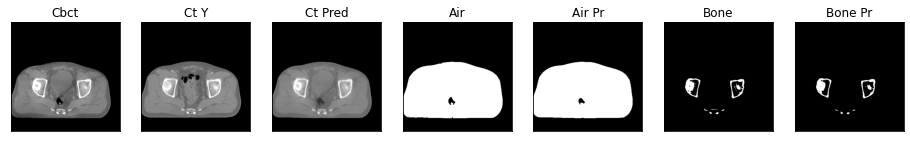

ssim score = 0.8901102542877197
psnr score = 25.141433715820312
snr score = 15.687775611877441
mae error = 0.018908372148871422
air dice score = 0.9979428342058186
bone dice score = 0.9575347613687047


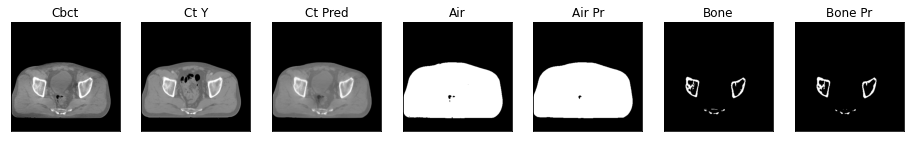

ssim score = 0.8908112049102783
psnr score = 25.011384963989258
snr score = 15.491999626159668
mae error = 0.01906932331621647
air dice score = 0.9980241159185345
bone dice score = 0.9645861866569245


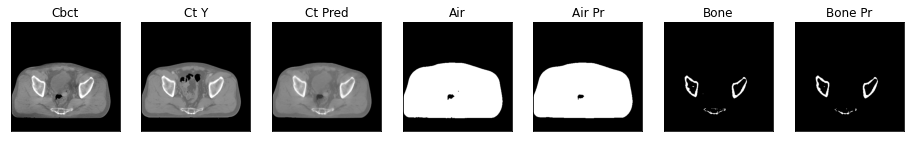

13it [00:29,  2.23s/it]

ssim score = 0.8895357251167297
psnr score = 25.086566925048828
snr score = 15.56688117980957
mae error = 0.019138386473059654
air dice score = 0.9975105715454938
bone dice score = 0.9634482758626992


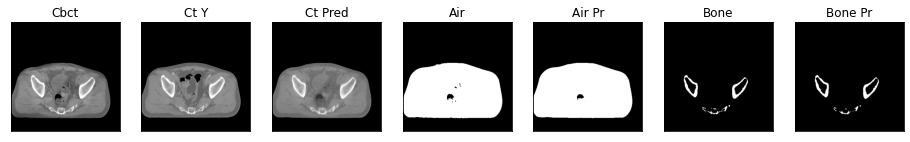

ssim score = 0.885306715965271
psnr score = 25.05286407470703
snr score = 15.609345436096191
mae error = 0.020209085196256638
air dice score = 0.9971850385227933
bone dice score = 0.9587123862846926


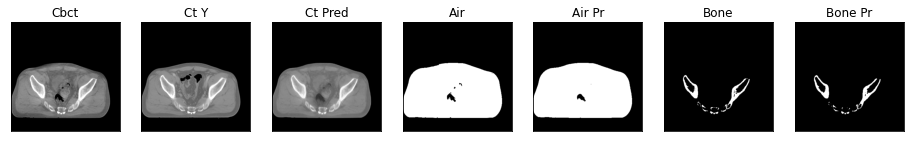

ssim score = 0.8910489082336426
psnr score = 25.464258193969727
snr score = 16.056320190429688
mae error = 0.019288865849375725
air dice score = 0.9963209135241168
bone dice score = 0.958219445529634


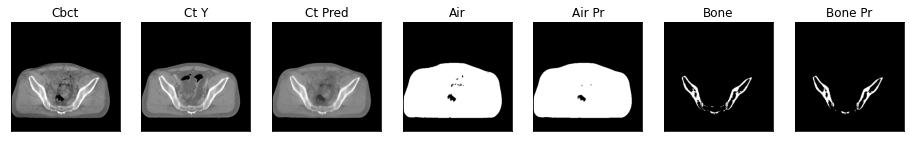

ssim score = 0.893690288066864
psnr score = 26.233884811401367
snr score = 16.76424789428711
mae error = 0.0179107915610075
air dice score = 0.9959958475456063
bone dice score = 0.9482591205444825


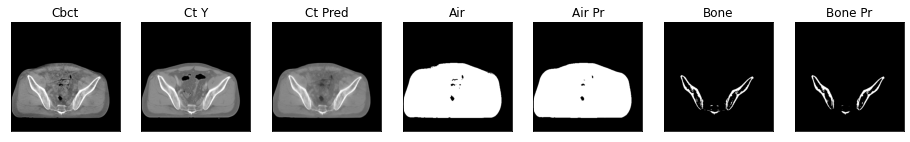

ssim score = 0.887794017791748
psnr score = 26.04831314086914
snr score = 16.517414093017578
mae error = 0.018193215131759644
air dice score = 0.9955429497568921
bone dice score = 0.9500651324366759


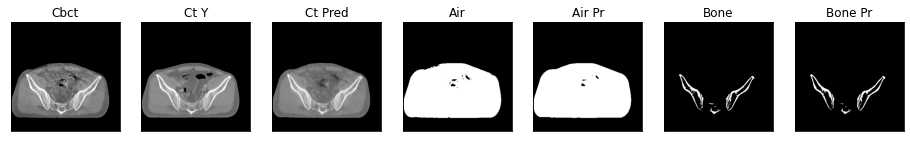

ssim score = 0.8038964867591858
psnr score = 22.454111099243164
snr score = 14.151416778564453
mae error = 0.03091566450893879
air dice score = 0.9985776439089701
bone dice score = 0.9842370744015058


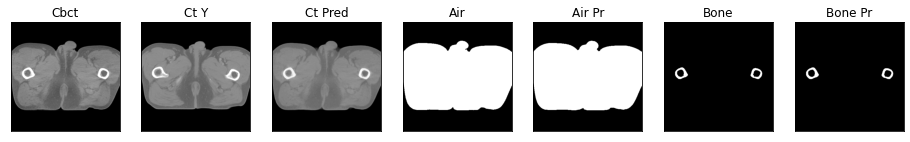

ssim score = 0.7956190705299377
psnr score = 22.096717834472656
snr score = 13.898314476013184
mae error = 0.031805768609046936
air dice score = 0.9987527172944664
bone dice score = 0.9810894721992354


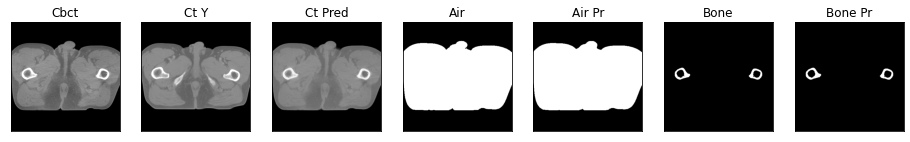

ssim score = 0.7893933653831482
psnr score = 21.824342727661133
snr score = 13.753896713256836
mae error = 0.033461738377809525
air dice score = 0.998874954109971
bone dice score = 0.9671171171178577


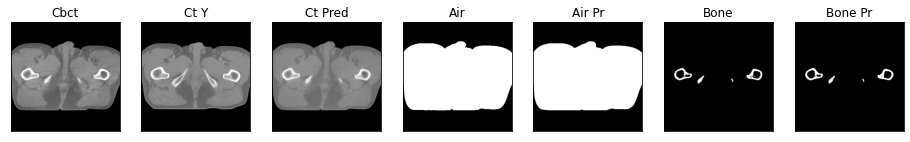

14it [00:31,  2.19s/it]

ssim score = 0.7818049788475037
psnr score = 21.53094482421875
snr score = 13.492788314819336
mae error = 0.03432144969701767
air dice score = 0.9987775855247236
bone dice score = 0.9721762172909544


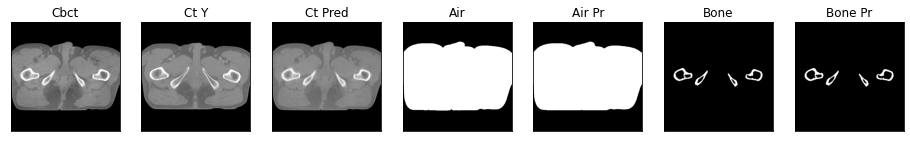

ssim score = 0.7730111479759216
psnr score = 21.43303871154785
snr score = 13.425121307373047
mae error = 0.03526151180267334
air dice score = 0.9987338417596663
bone dice score = 0.9599356395823019


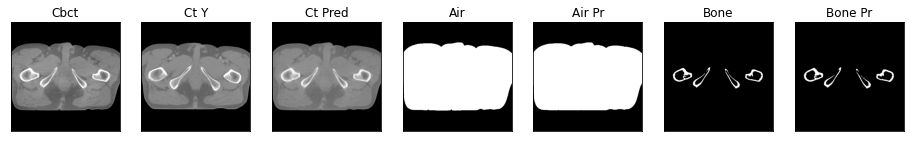

ssim score = 0.7651068568229675
psnr score = 21.29790496826172
snr score = 13.324403762817383
mae error = 0.036587636917829514
air dice score = 0.9985560838175743
bone dice score = 0.9639804639810138


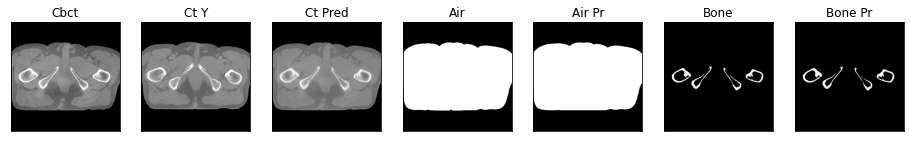

ssim score = 0.7566344141960144
psnr score = 20.980302810668945
snr score = 13.027111053466797
mae error = 0.038299765437841415
air dice score = 0.9983504913430051
bone dice score = 0.9651116160945714


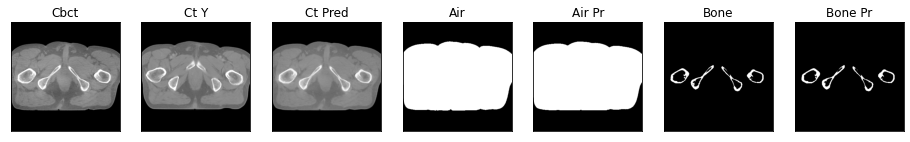

ssim score = 0.7565194368362427
psnr score = 21.022544860839844
snr score = 13.108426094055176
mae error = 0.0377727746963501
air dice score = 0.9989071293736748
bone dice score = 0.9600532623174427


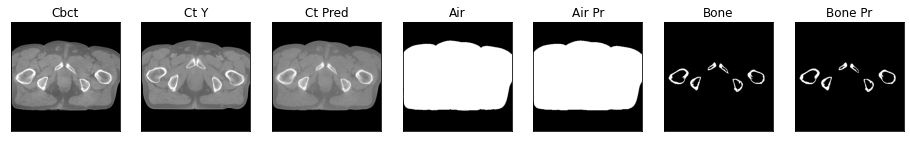

ssim score = 0.7549149394035339
psnr score = 21.177217483520508
snr score = 13.31177806854248
mae error = 0.037410248070955276
air dice score = 0.9993216691616771
bone dice score = 0.966984782048401


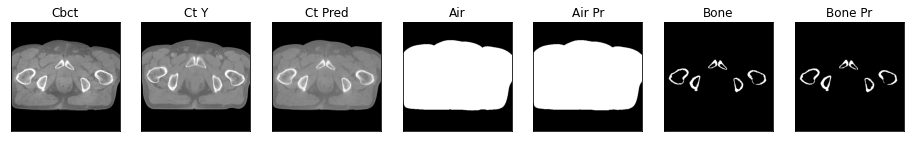

ssim score = 0.7513827085494995
psnr score = 21.04010772705078
snr score = 13.197280883789062
mae error = 0.0388837568461895
air dice score = 0.999228836828884
bone dice score = 0.9648340762758193


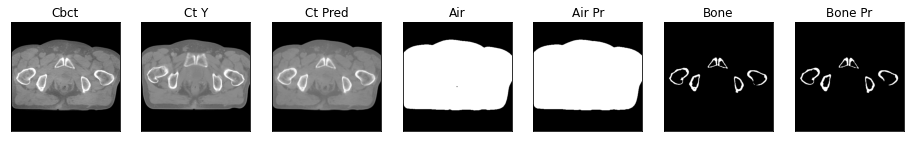

ssim score = 0.73920738697052
psnr score = 20.94928741455078
snr score = 13.149237632751465
mae error = 0.04020629823207855
air dice score = 0.9988526700174145
bone dice score = 0.9633593113881196


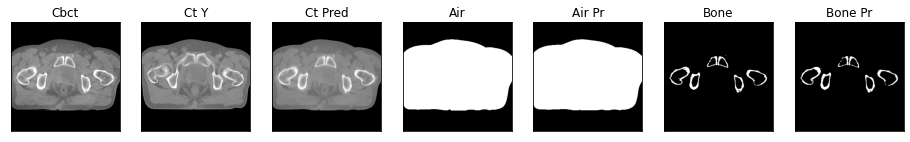

15it [00:33,  2.22s/it]

ssim score = 0.7376940846443176
psnr score = 20.978796005249023
snr score = 13.237085342407227
mae error = 0.0403880700469017
air dice score = 0.9986178861788626
bone dice score = 0.9667302394578647


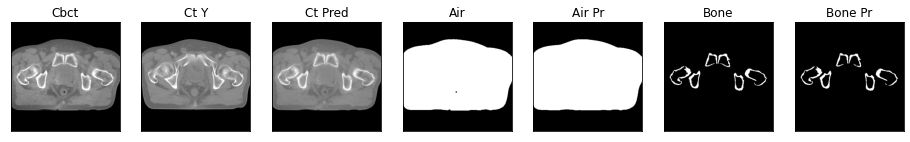

ssim score = 0.7306088805198669
psnr score = 20.632164001464844
snr score = 12.815083503723145
mae error = 0.043063629418611526
air dice score = 0.9986314080259808
bone dice score = 0.9574794100751055


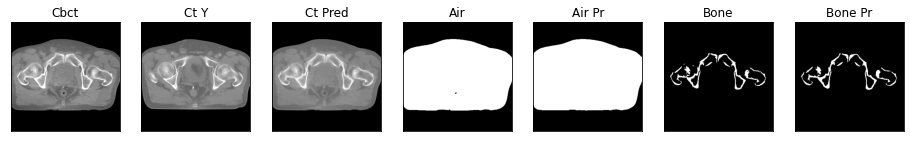

ssim score = 0.7331737279891968
psnr score = 20.425155639648438
snr score = 12.5008544921875
mae error = 0.04422955587506294
air dice score = 0.998550237181198
bone dice score = 0.9458165085928649


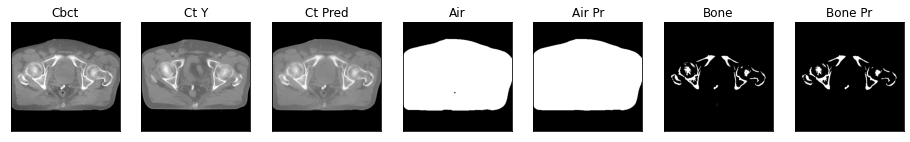

ssim score = 0.7450145483016968
psnr score = 20.536407470703125
snr score = 12.489019393920898
mae error = 0.04380987957119942
air dice score = 0.998845017614933
bone dice score = 0.9492952590156571


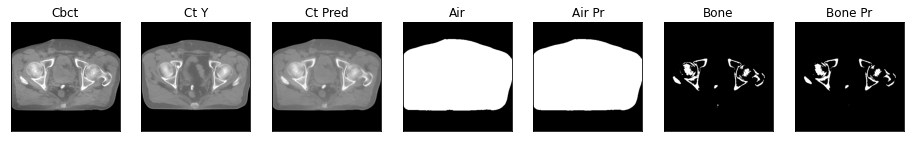

ssim score = 0.7497856616973877
psnr score = 20.73213768005371
snr score = 12.572320938110352
mae error = 0.042729634791612625
air dice score = 0.9988538181818188
bone dice score = 0.9569414944974228


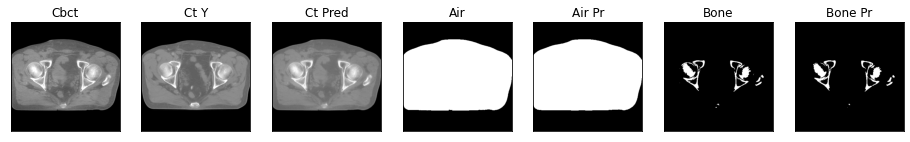

ssim score = 0.7457096576690674
psnr score = 21.004138946533203
snr score = 12.793672561645508
mae error = 0.04034676402807236
air dice score = 0.9989497636968324
bone dice score = 0.9661520190027103


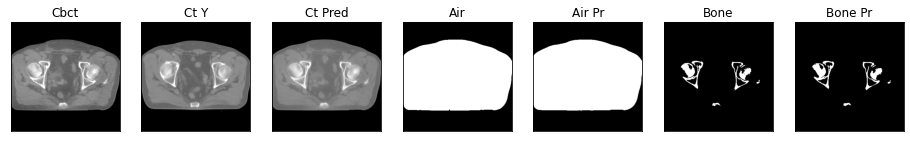

ssim score = 0.7450416088104248
psnr score = 20.866600036621094
snr score = 12.688287734985352
mae error = 0.0408780612051487
air dice score = 0.9988759308697491
bone dice score = 0.9620656678359147


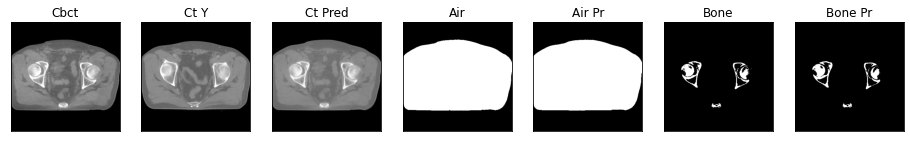

ssim score = 0.7439457774162292
psnr score = 20.67695426940918
snr score = 12.51212215423584
mae error = 0.04175277799367905
air dice score = 0.9990358272484632
bone dice score = 0.959889349931306


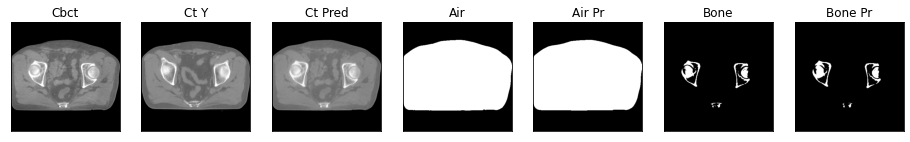

16it [00:35,  2.18s/it]

ssim score = 0.7416779398918152
psnr score = 20.327150344848633
snr score = 12.02082633972168
mae error = 0.04342736676335335
air dice score = 0.9988416486413019
bone dice score = 0.966343411295307


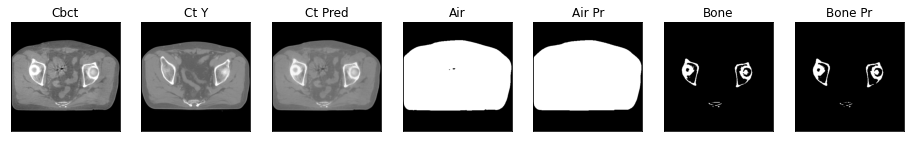

ssim score = 0.7511364817619324
psnr score = 20.36300277709961
snr score = 11.997366905212402
mae error = 0.043055858463048935
air dice score = 0.9992457222951427
bone dice score = 0.9660174613839353


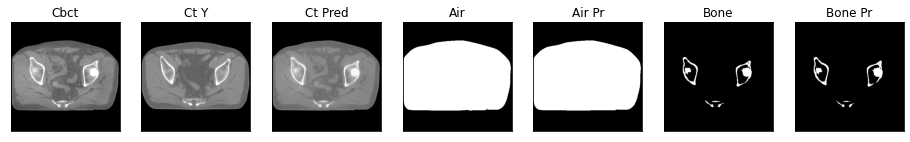

ssim score = 0.7504349946975708
psnr score = 20.72226333618164
snr score = 12.38227653503418
mae error = 0.04050777852535248
air dice score = 0.9991582642333942
bone dice score = 0.948237059265787


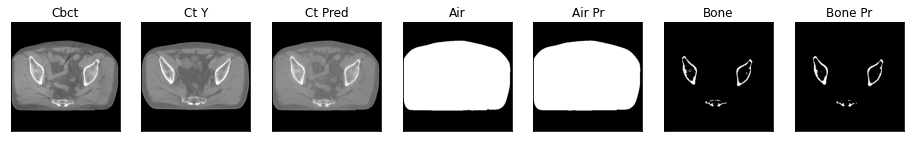

ssim score = 0.7439316511154175
psnr score = 20.684524536132812
snr score = 12.417350769042969
mae error = 0.04061239957809448
air dice score = 0.9990091577841171
bone dice score = 0.9556752998443303


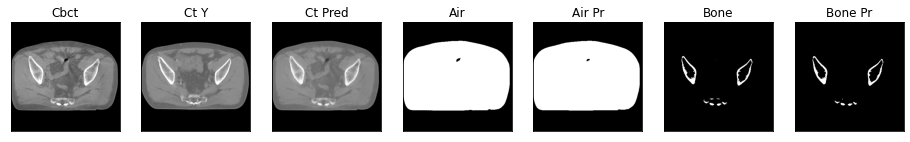

ssim score = 0.7366010546684265
psnr score = 20.439626693725586
snr score = 12.301684379577637
mae error = 0.042148660868406296
air dice score = 0.9985499365597253
bone dice score = 0.9612955465593312


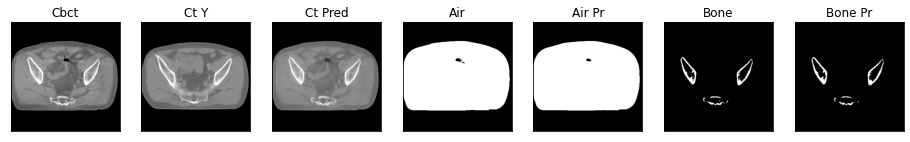

ssim score = 0.7305744886398315
psnr score = 20.31633758544922
snr score = 12.21235466003418
mae error = 0.04287843778729439
air dice score = 0.9986081481076293
bone dice score = 0.9592227292807416


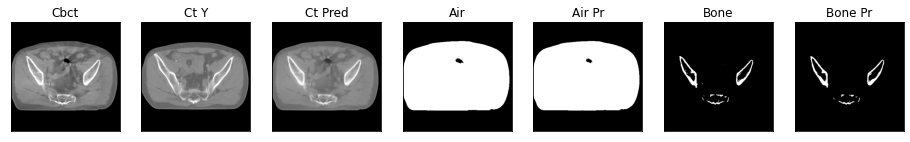

ssim score = 0.7197123169898987
psnr score = 20.19156265258789
snr score = 12.057788848876953
mae error = 0.04389902204275131
air dice score = 0.9986953765119009
bone dice score = 0.9593824228033326


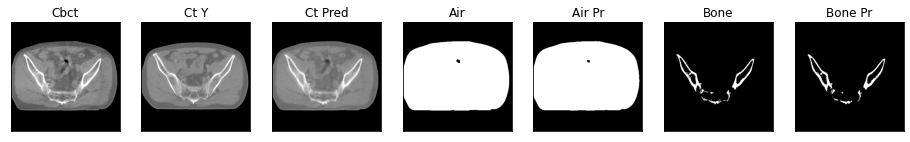

ssim score = 0.7204628586769104
psnr score = 20.341482162475586
snr score = 12.14433479309082
mae error = 0.04272402077913284
air dice score = 0.9990403364323749
bone dice score = 0.9555834378926527


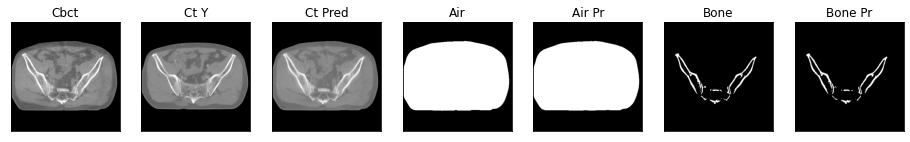

17it [00:37,  2.22s/it]

ssim score = 0.8500964045524597
psnr score = 24.210603713989258
snr score = 15.687995910644531
mae error = 0.02329820580780506
air dice score = 0.9977606781087516
bone dice score = 0.9473307058408296


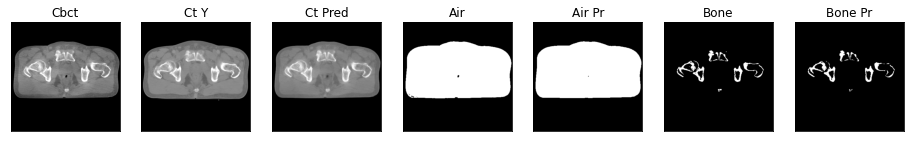

ssim score = 0.8558363318443298
psnr score = 24.46661376953125
snr score = 15.984018325805664
mae error = 0.022327955812215805
air dice score = 0.9978170212125335
bone dice score = 0.9398514851492593


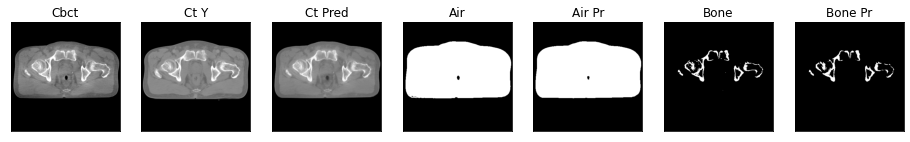

ssim score = 0.8557525873184204
psnr score = 24.667484283447266
snr score = 16.19267463684082
mae error = 0.022138306871056557
air dice score = 0.9980787052733904
bone dice score = 0.9372493207408817


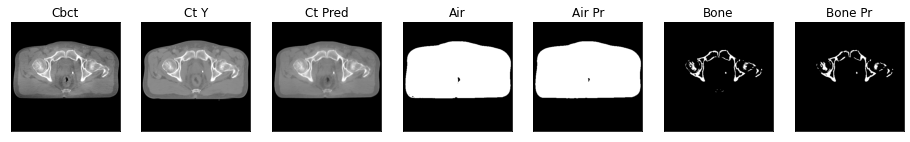

ssim score = 0.8608558177947998
psnr score = 24.740459442138672
snr score = 16.207229614257812
mae error = 0.021512581035494804
air dice score = 0.9982468072243647
bone dice score = 0.935244806221173


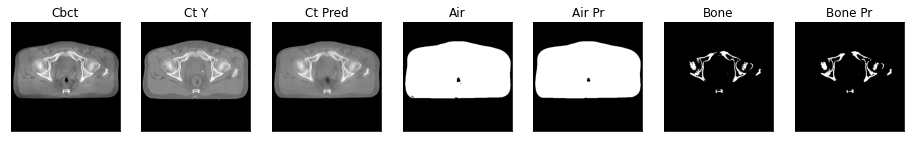

ssim score = 0.867381751537323
psnr score = 24.88421630859375
snr score = 16.195363998413086
mae error = 0.02036959119141102
air dice score = 0.9983253896689437
bone dice score = 0.9344746162937652


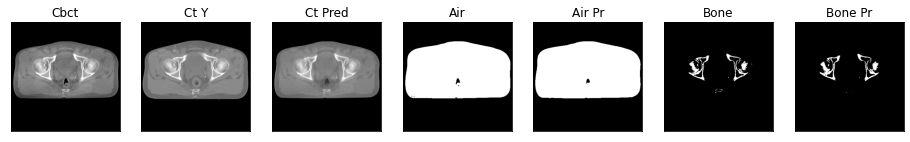

ssim score = 0.8708377480506897
psnr score = 25.04235076904297
snr score = 16.332693099975586
mae error = 0.019910158589482307
air dice score = 0.9986247977085038
bone dice score = 0.9479512735333894


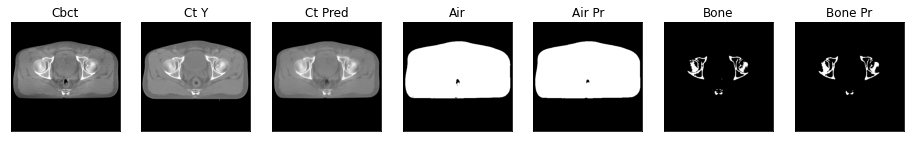

ssim score = 0.8669816255569458
psnr score = 24.99768829345703
snr score = 16.27239990234375
mae error = 0.020318621769547462
air dice score = 0.9980412630423696
bone dice score = 0.9512559402586388


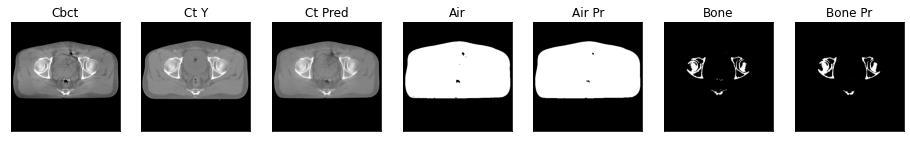

ssim score = 0.86043381690979
psnr score = 24.44217872619629
snr score = 15.726259231567383
mae error = 0.021731389686465263
air dice score = 0.997687701943251
bone dice score = 0.9487354750519653


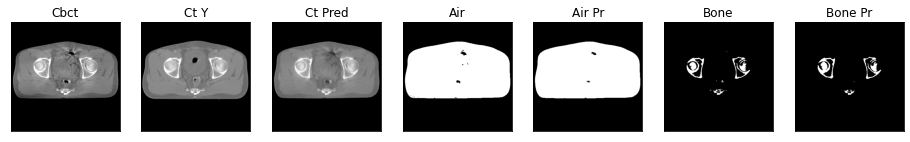

18it [00:39,  2.17s/it]

ssim score = 0.8555100560188293
psnr score = 24.451080322265625
snr score = 15.790937423706055
mae error = 0.02250942774116993
air dice score = 0.9959918916428668
bone dice score = 0.9588712897649558


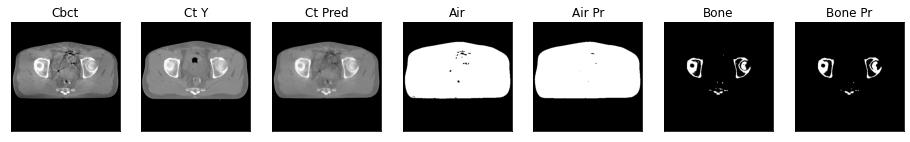

ssim score = 0.8547728657722473
psnr score = 24.078454971313477
snr score = 15.396383285522461
mae error = 0.023538166657090187
air dice score = 0.9961249603601264
bone dice score = 0.9595533160838955


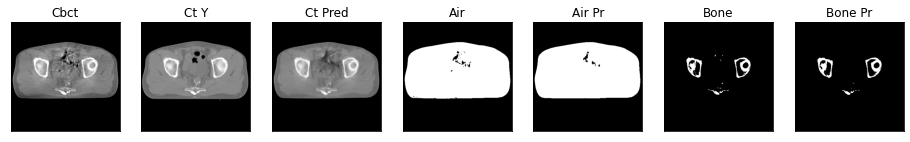

ssim score = 0.855067253112793
psnr score = 23.520278930664062
snr score = 14.76743221282959
mae error = 0.023904236033558846
air dice score = 0.9960861664621771
bone dice score = 0.9522944116317993


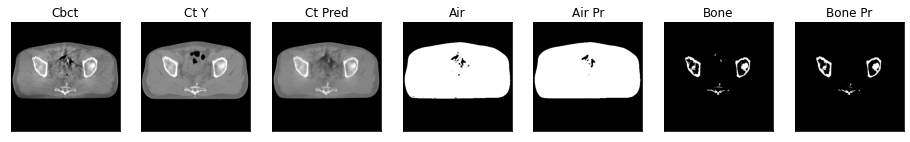

ssim score = 0.8586810827255249
psnr score = 23.84829330444336
snr score = 15.051554679870605
mae error = 0.022921977564692497
air dice score = 0.9969275173409083
bone dice score = 0.9530569446692522


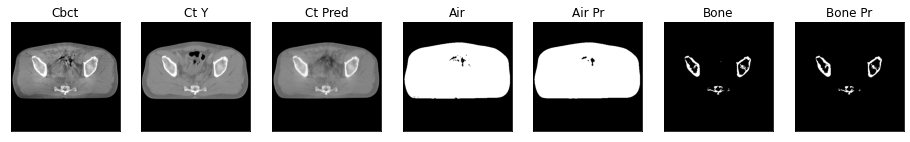

ssim score = 0.8613891005516052
psnr score = 24.125713348388672
snr score = 15.327878952026367
mae error = 0.02262224815785885
air dice score = 0.9965850129520606
bone dice score = 0.9539814669396265


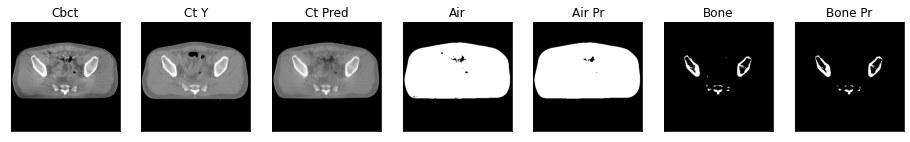

ssim score = 0.8604791164398193
psnr score = 24.21441650390625
snr score = 15.429935455322266
mae error = 0.023330610245466232
air dice score = 0.9962008757568903
bone dice score = 0.9556324259293784


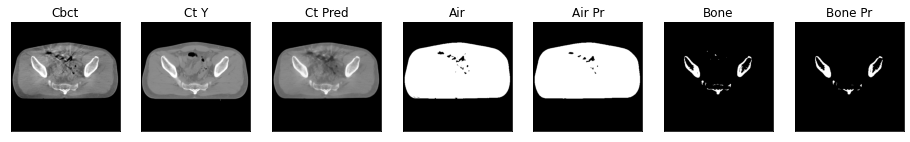

ssim score = 0.858517050743103
psnr score = 24.36275863647461
snr score = 15.633485794067383
mae error = 0.023387955501675606
air dice score = 0.9959654903934662
bone dice score = 0.9596703708333166


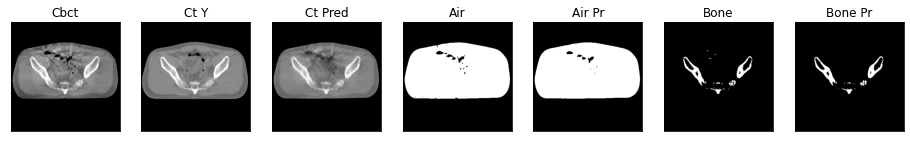

ssim score = 0.8599291443824768
psnr score = 23.91045379638672
snr score = 15.20054817199707
mae error = 0.023541370406746864
air dice score = 0.9965326482686909
bone dice score = 0.9509703779372961


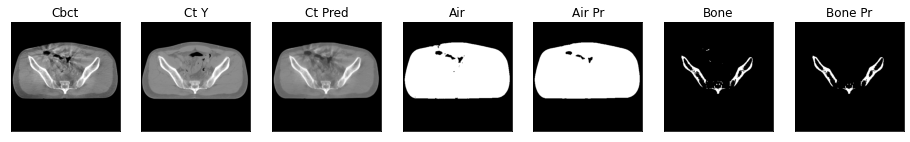

19it [00:42,  2.21s/it]

ssim score = 0.8637095093727112
psnr score = 23.709333419799805
snr score = 14.94469165802002
mae error = 0.023676253855228424
air dice score = 0.9961264112617537
bone dice score = 0.9490383265485184


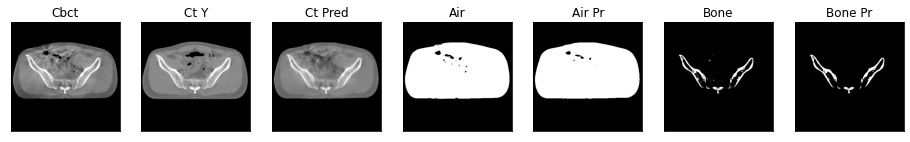

ssim score = 0.8651605248451233
psnr score = 23.82625961303711
snr score = 15.025264739990234
mae error = 0.02289166860282421
air dice score = 0.9967621772000717
bone dice score = 0.9476801579474309


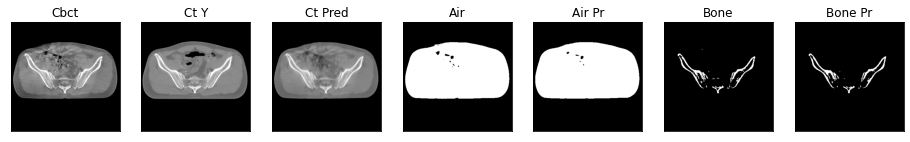

ssim score = 0.8681306838989258
psnr score = 24.013425827026367
snr score = 15.212499618530273
mae error = 0.022201836109161377
air dice score = 0.9966133658114984
bone dice score = 0.9465976518123141


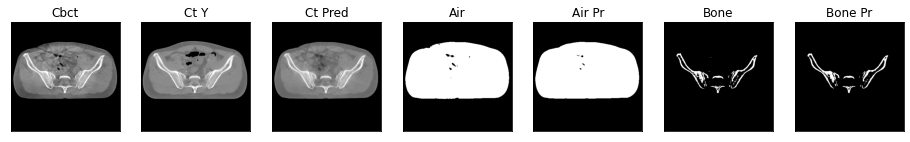

ssim score = 0.8664699792861938
psnr score = 24.2134952545166
snr score = 15.411149024963379
mae error = 0.022402137517929077
air dice score = 0.996670208997523
bone dice score = 0.9452353469290081


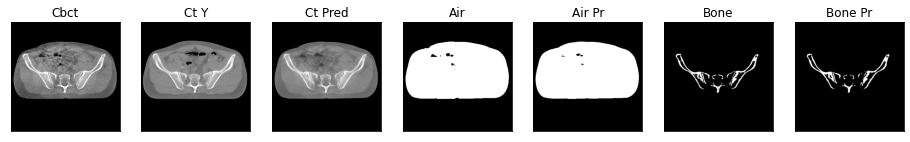

ssim score = 0.8596979975700378
psnr score = 23.717361450195312
snr score = 14.920053482055664
mae error = 0.02383565343916416
air dice score = 0.9963720473376559
bone dice score = 0.9325626204247583


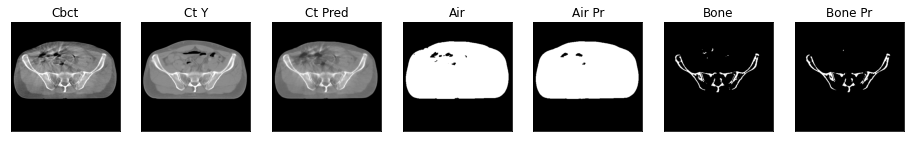

ssim score = 0.8525922298431396
psnr score = 23.31322479248047
snr score = 14.498644828796387
mae error = 0.02517411671578884
air dice score = 0.9958371877890875
bone dice score = 0.9306174411211888


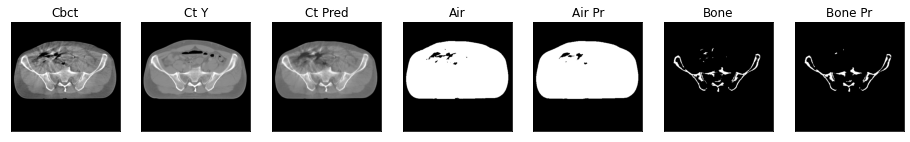

ssim score = 0.8483373522758484
psnr score = 22.93950080871582
snr score = 14.106300354003906
mae error = 0.026580937206745148
air dice score = 0.9956174024312255
bone dice score = 0.9303835517622894


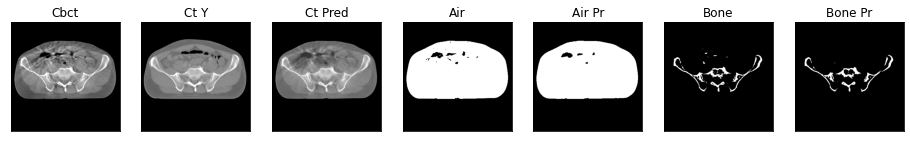

ssim score = 0.8384605646133423
psnr score = 22.413070678710938
snr score = 13.533927917480469
mae error = 0.027811000123620033
air dice score = 0.9954253611557019
bone dice score = 0.9320074005558278


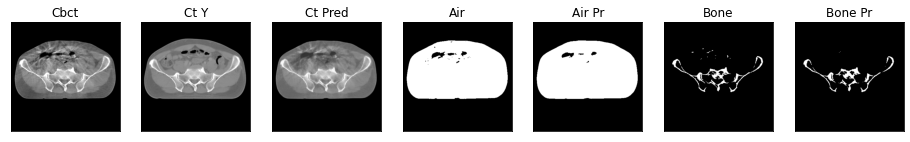

20it [00:44,  2.23s/it]

ssim score = 0.8313852548599243
psnr score = 22.44455337524414
snr score = 13.511614799499512
mae error = 0.028305822983384132
air dice score = 0.9954103649929458
bone dice score = 0.9364556098677225


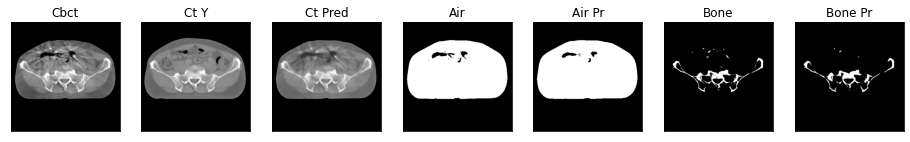

ssim score = 0.8231799006462097
psnr score = 22.080705642700195
snr score = 13.178229331970215
mae error = 0.030011359602212906
air dice score = 0.9957073202339141
bone dice score = 0.9421229050285796


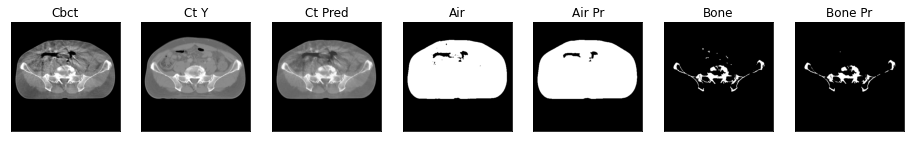

ssim score = 0.8170999884605408
psnr score = 21.669696807861328
snr score = 12.711997032165527
mae error = 0.030875159427523613
air dice score = 0.9960573709316318
bone dice score = 0.9387563183268042


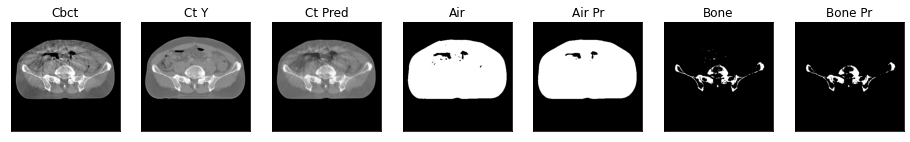

ssim score = 0.8238990902900696
psnr score = 22.403457641601562
snr score = 13.298224449157715
mae error = 0.028358999639749527
air dice score = 0.9967245013783065
bone dice score = 0.9450603596951828


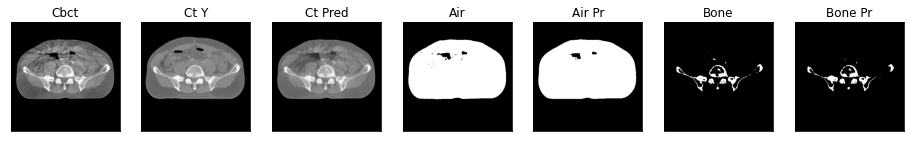

ssim score = 0.8797374963760376
psnr score = 26.56348991394043
snr score = 16.944400787353516
mae error = 0.01885583996772766
air dice score = 0.9987897984491501
bone dice score = 0.9719880337239056


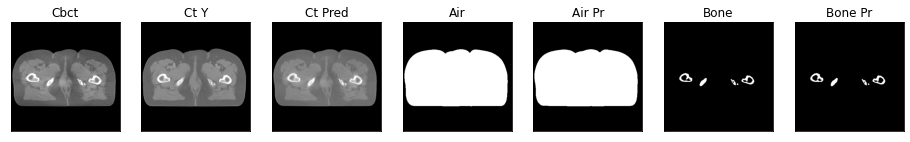

ssim score = 0.8796637058258057
psnr score = 26.745527267456055
snr score = 17.247451782226562
mae error = 0.018684357404708862
air dice score = 0.9986860566109178
bone dice score = 0.9752829752835462


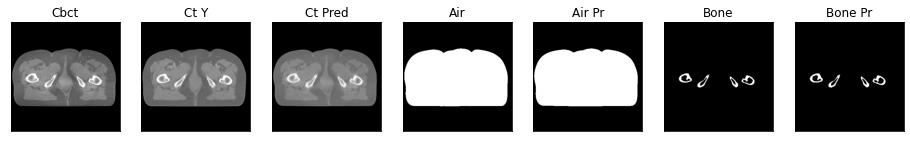

ssim score = 0.8759459853172302
psnr score = 26.649478912353516
snr score = 17.23431968688965
mae error = 0.019230064004659653
air dice score = 0.9986126280367221
bone dice score = 0.9661895872232692


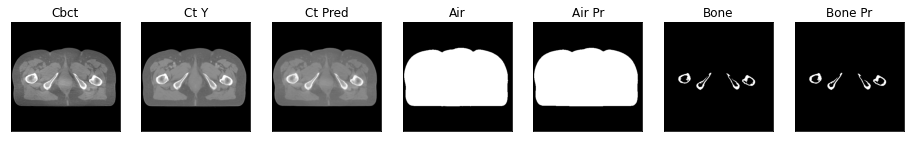

ssim score = 0.8734774589538574
psnr score = 26.529361724853516
snr score = 17.177648544311523
mae error = 0.019680602476000786
air dice score = 0.9987446132160669
bone dice score = 0.963371986012086


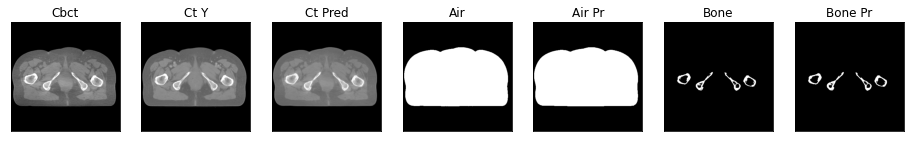

21it [00:46,  2.18s/it]

ssim score = 0.8742443323135376
psnr score = 26.39147186279297
snr score = 17.068220138549805
mae error = 0.02003617025911808
air dice score = 0.9986093626489456
bone dice score = 0.965891201679799


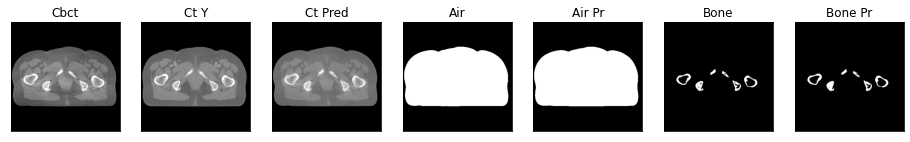

ssim score = 0.8766177296638489
psnr score = 26.37346649169922
snr score = 17.073169708251953
mae error = 0.019839702174067497
air dice score = 0.9988175009854167
bone dice score = 0.9644036697254238


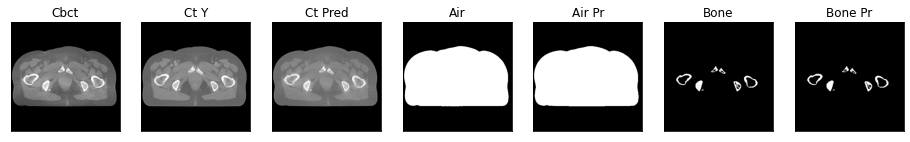

ssim score = 0.8740534782409668
psnr score = 26.268951416015625
snr score = 16.999980926513672
mae error = 0.020010987296700478
air dice score = 0.9986816132392262
bone dice score = 0.9642341040468888


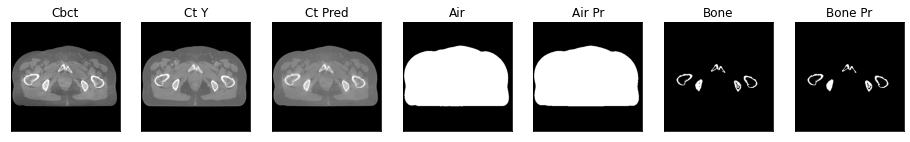

ssim score = 0.8732091784477234
psnr score = 26.172657012939453
snr score = 16.952049255371094
mae error = 0.02046651765704155
air dice score = 0.9979183043642837
bone dice score = 0.95725891911061


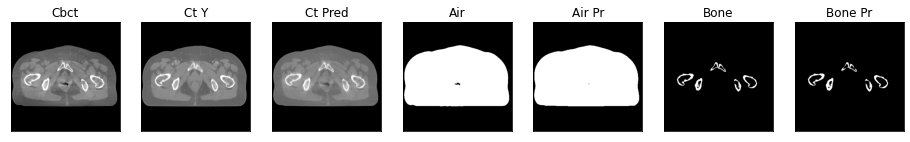

ssim score = 0.8730644583702087
psnr score = 26.053218841552734
snr score = 16.875356674194336
mae error = 0.0203887727111578
air dice score = 0.9980337610509925
bone dice score = 0.9600000000006611


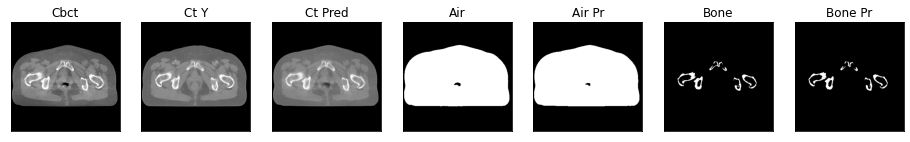

ssim score = 0.8727895617485046
psnr score = 26.13511848449707
snr score = 17.04495620727539
mae error = 0.02047620341181755
air dice score = 0.9982156772779259
bone dice score = 0.9536931818188396


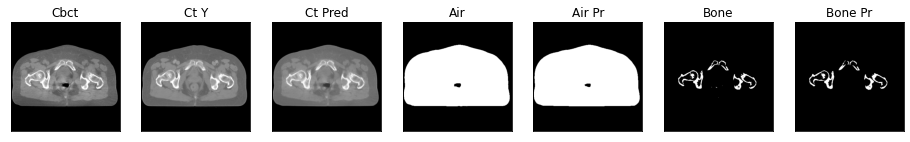

ssim score = 0.8755085468292236
psnr score = 26.741125106811523
snr score = 17.764238357543945
mae error = 0.01976744271814823
air dice score = 0.9984338292873934
bone dice score = 0.9573392878134053


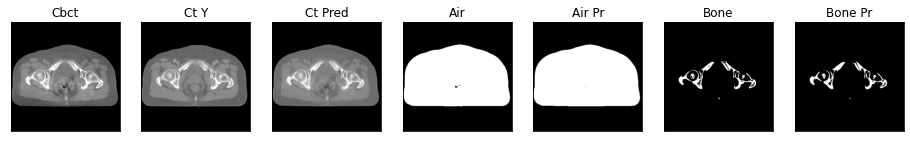

ssim score = 0.8783562183380127
psnr score = 26.66997528076172
snr score = 17.56453514099121
mae error = 0.019415568560361862
air dice score = 0.9981678590123901
bone dice score = 0.9468500594337435


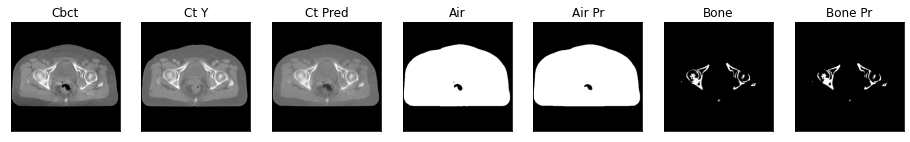

22it [00:48,  2.21s/it]

ssim score = 0.8814520835876465
psnr score = 26.972545623779297
snr score = 17.7576847076416
mae error = 0.018851198256015778
air dice score = 0.9983734406087992
bone dice score = 0.9370199692792431


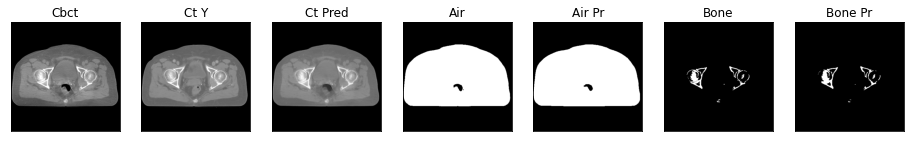

ssim score = 0.8835136890411377
psnr score = 26.906583786010742
snr score = 17.664592742919922
mae error = 0.019547995179891586
air dice score = 0.9982414624085465
bone dice score = 0.9464529331523456


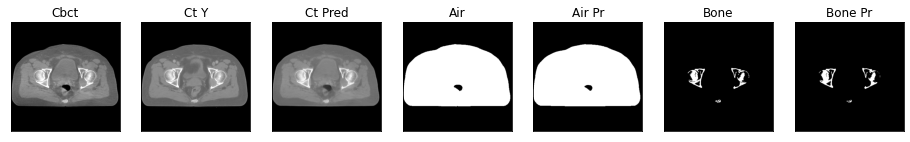

ssim score = 0.8850329518318176
psnr score = 26.938072204589844
snr score = 17.688081741333008
mae error = 0.020200908184051514
air dice score = 0.9985653415204521
bone dice score = 0.9561216105183875


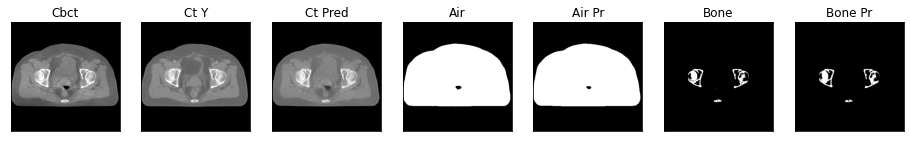

ssim score = 0.8832976222038269
psnr score = 27.26315689086914
snr score = 18.047393798828125
mae error = 0.019542623311281204
air dice score = 0.9990545852614825
bone dice score = 0.9598255995023385


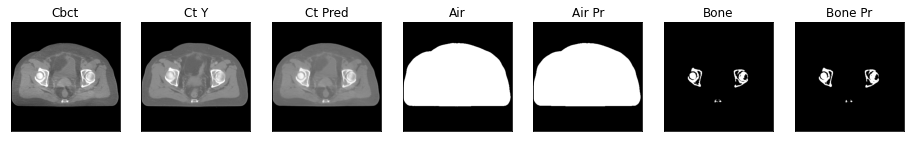

ssim score = 0.8779929280281067
psnr score = 26.609806060791016
snr score = 17.44553565979004
mae error = 0.02047491818666458
air dice score = 0.9988921895837605
bone dice score = 0.9689557855131866


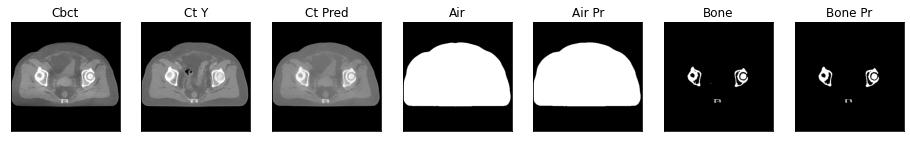

ssim score = 0.8650918006896973
psnr score = 25.6061954498291
snr score = 16.479480743408203
mae error = 0.021723398938775063
air dice score = 0.9988734562502195
bone dice score = 0.9690121554533639


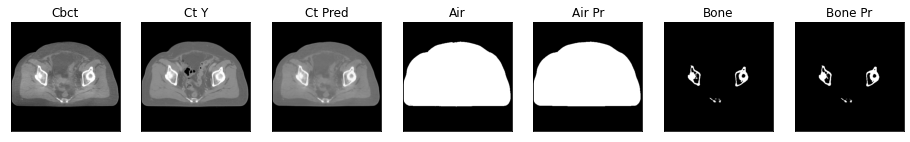

ssim score = 0.8493971824645996
psnr score = 24.205577850341797
snr score = 15.006427764892578
mae error = 0.02420743554830551
air dice score = 0.9976015850394538
bone dice score = 0.9593423683634894


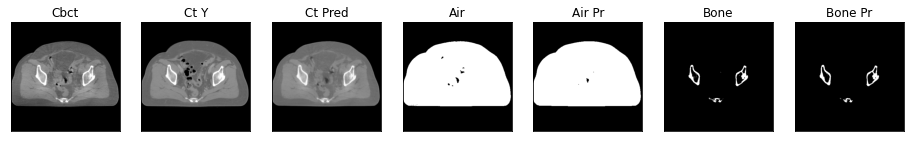

ssim score = 0.8404168486595154
psnr score = 24.263362884521484
snr score = 15.046220779418945
mae error = 0.024615347385406494
air dice score = 0.9974685645516057
bone dice score = 0.9662569832409775


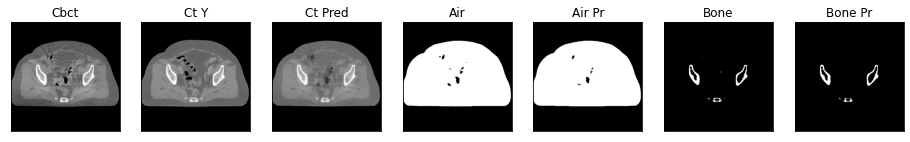

23it [00:50,  2.17s/it]

ssim score = 0.836804986000061
psnr score = 24.692670822143555
snr score = 15.540441513061523
mae error = 0.02397681586444378
air dice score = 0.9971805926230088
bone dice score = 0.9670471677801626


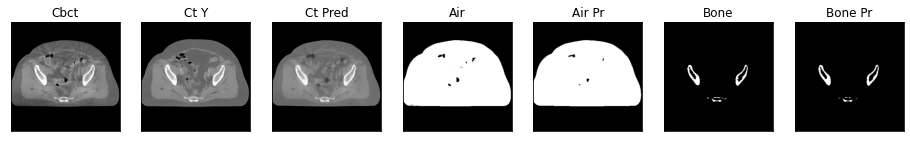

ssim score = 0.8374423980712891
psnr score = 24.597782135009766
snr score = 15.500649452209473
mae error = 0.024730632081627846
air dice score = 0.9972372502834044
bone dice score = 0.967658948916434


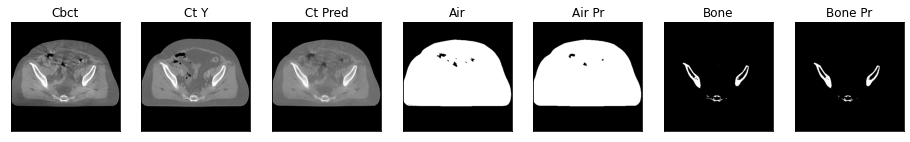

ssim score = 0.8327967524528503
psnr score = 23.925052642822266
snr score = 14.892345428466797
mae error = 0.02660183608531952
air dice score = 0.9969699616374321
bone dice score = 0.9612903225812398


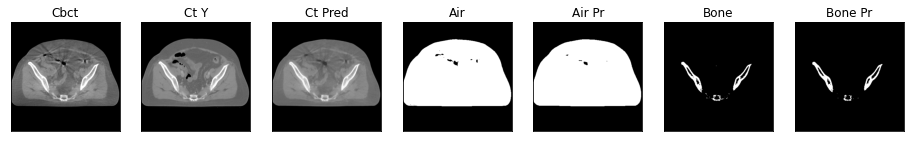

ssim score = 0.8312181234359741
psnr score = 23.821693420410156
snr score = 14.861846923828125
mae error = 0.02719772607088089
air dice score = 0.9966998459928152
bone dice score = 0.9573687182388853


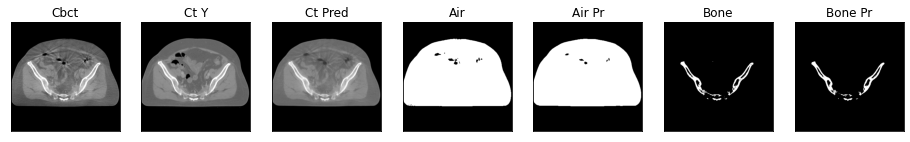

ssim score = 0.8331958651542664
psnr score = 23.84716796875
snr score = 14.883031845092773
mae error = 0.027445156127214432
air dice score = 0.9968510604517029
bone dice score = 0.9445238776101726


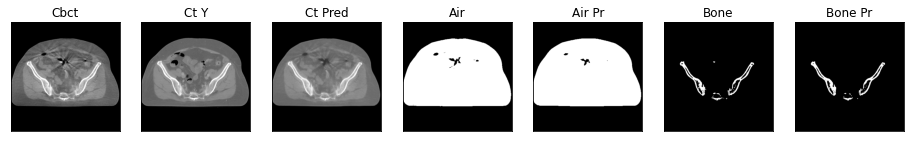

ssim score = 0.8315296173095703
psnr score = 23.683944702148438
snr score = 14.697629928588867
mae error = 0.027780456468462944
air dice score = 0.9969173173461461
bone dice score = 0.9511482254704086


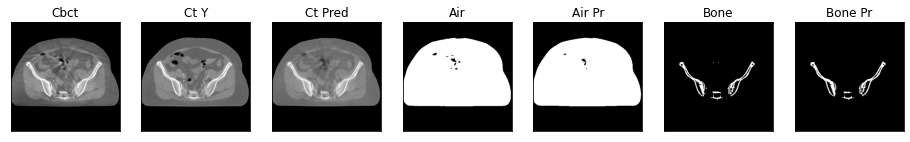

ssim score = 0.8379026055335999
psnr score = 24.2918701171875
snr score = 15.317191123962402
mae error = 0.02629592828452587
air dice score = 0.9973439747094585
bone dice score = 0.9501466275667134


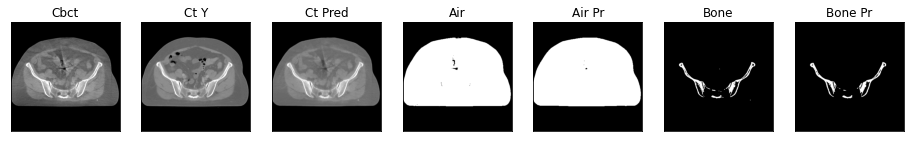

24it [00:53,  2.21s/it]


In [33]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [34]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [36]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:06,  3.43it/s]


(0.8494076132774353,
 24.09140197436015,
 15.105972488721212,
 0.02486324100755155,
 0.9962992583359455,
 0.9588367133233132,
 0.3333333333333333)

In [37]:
# import torchvision.models as models
# models.vgg16(pretrained=True)